In [1]:
import tensorflow as tf
import tensorflow.contrib.eager as tfe
import numpy as np
import pandas as pd
import pickle
from timeit import default_timer as timer
import matplotlib.pyplot as plt

import sklearn
from sklearn.model_selection import train_test_split
import nltk as nltk
import math
import collections

from IPython.display import display
import os
import cProfile, pstats, io
#import memory_profiler
import psutil
import gc

# Enabling eager execution and set other configurations

In [2]:
tf.enable_eager_execution()
process = psutil.Process(os.getpid())

print(process.memory_info().rss / (1024*1024), 'MB') # to get memory used by this process in MB
#https://stackoverflow.com/questions/938733/total-memory-used-by-python-process

#https://pypi.org/project/memory-profiler/ - did not use it

UNK = '</s>'
FILLER = '</fill>'

MAX_WORD_COUNT = 10

NO_LABEL = 'NO_LABEL'

STATE_SIZE = 30

#tf.set_random_seed(1)

359.796875 MB


# Load Google vectors

In [3]:
print(process.memory_info().rss / (1024*1024), 'MB') # to get memory used by this process in MB

dirname = os.getcwd()
datasetPath = os.path.join(dirname, 'datasets/')
outfile = datasetPath +'google_word_corpus.pic'

with open(outfile, 'rb') as pickle_file:    
    googleCorpus, google_corpus_word_to_int, google_corpus_int_to_word = pickle.load(pickle_file)
googleSet = pd.read_csv(datasetPath+'GoogleNews-vectors-negative300.txt', sep=' ', 
                        header=None, prefix='c')

print(len(googleCorpus))
print(len(google_corpus_word_to_int))
print(len(google_corpus_int_to_word))
print(googleSet.shape)
print(googleSet.head())

googleWords = googleSet.iloc[:,0:1]
googleVectors = googleSet.iloc[:,1:STATE_SIZE+1]
#googleVectors = googleVectors.apply(pd.Series.astype, args=(np.float64,), axis=1)
#googleVectors.dtypes
print(process.memory_info().rss / (1024*1024), 'MB') # to get memory used by this process in MB
print(googleVectors.head(2))

359.796875 MB
31462
31462
31462
(31462, 301)
     c0        c1        c2        c3        c4        c5        c6        c7  \
0  </s>  0.001129 -0.000896  0.000319  0.001534  0.001106 -0.001404 -0.000031   
1    in  0.070312  0.086914  0.087891  0.062500  0.069336 -0.108887 -0.081543   
2   for -0.011780 -0.047363  0.044678  0.063477 -0.018188 -0.063965 -0.001312   
3  that -0.015747 -0.028320  0.083496  0.050293 -0.110352  0.031738 -0.014221   
4    is  0.007050 -0.073242  0.171875  0.022583 -0.132812  0.198242  0.112793   

         c8        c9  ...      c291      c292      c293      c294      c295  \
0 -0.000420 -0.000576  ... -0.001549  0.001373 -0.000061 -0.000824  0.001328   
1 -0.154297  0.020752  ... -0.168945 -0.088867 -0.080566  0.064941  0.061279   
2 -0.072266  0.064453  ... -0.022583  0.003723 -0.082520  0.081543  0.007935   
3 -0.089844  0.117676  ... -0.011292 -0.015625 -0.033447 -0.020630 -0.019409   
4 -0.107910  0.071777  ... -0.233398 -0.036377 -0.093750  0.182617  

# Load training and test dataset

518.51171875 MB
                                            sentence  \
0  there is no asbestos in our products now </s> ...   
1     it has no bearing on our work force today </s>   
2  cray computer has applied </s> to trade on nas...   
3  esso said 0 the whiting field started producti...   
4  they expect him to cut costs throughout the or...   

                                                tree  
0  [[there], [[(NO_LABEL is), (NO_LABEL\n  (NO_LA...  
1  [[it], [[(NO_LABEL has), (NO_LABEL\n  (NO_LABE...  
2  [[[cray], [computer]], [[(NO_LABEL has), (NO_L...  
3  [[esso], [[(NO_LABEL said), (NO_LABEL\n  (NO_L...  
4  [[they], [[(NO_LABEL expect), (NO_LABEL\n  (NO...  
(486, 2)
sentence    object
tree        object
dtype: object


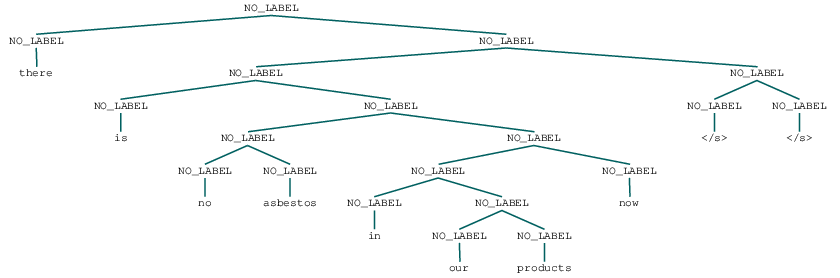

524.2890625 MB


In [4]:
print(process.memory_info().rss / (1024*1024), 'MB') # to get memory used by this process in MB

#treeDataframe = pd.read_csv(datasetPath+'constituency-parsing-data-all-UNK.csv', sep=' ', header=None )
#treeDataframe = pd.read_csv(datasetPath+'constituency-parsing-data-all-UNK-less-40-words.csv', sep=' ', header=None )
treeDataframe = pd.read_csv(datasetPath+'constituency-parsing-data-'+str(MAX_WORD_COUNT)+'-UNK-NOLABEL.csv', sep=' ', header=None )

treeDataframe.columns =['sentence', 'tree']
treeDataframe['tree'] = treeDataframe['tree'].apply(nltk.Tree.fromstring)

print(treeDataframe.head())
print(treeDataframe.shape)
print(treeDataframe.dtypes)
display(treeDataframe.iat[0,1])

print(process.memory_info().rss / (1024*1024), 'MB') # to get memory used by this process in MB

In [5]:
print(process.memory_info().rss / (1024*1024), 'MB') # to get memory used by this process in MB

def convert_imdb_corpus_into_int(sentence):
    words = sentence.split()
    words_to_num = [google_corpus_word_to_int[word] for word in words]
    return words_to_num

treeDataframe_num = treeDataframe.copy()
treeDataframe_num['sentence'] = treeDataframe_num['sentence'].apply(convert_imdb_corpus_into_int)

print(process.memory_info().rss / (1024*1024), 'MB') # to get memory used by this process in MB

print(treeDataframe_num.dtypes)
treeDataframe_num.head()

524.3203125 MB
524.37890625 MB
sentence    object
tree        object
dtype: object


,sentence,tree
0,"[64, 4, 77, 10083, 1, 63, 344, 88, 0, 0]","[[there], [[(NO_LABEL is), (NO_LABEL\n (NO_LA..."
1,"[13, 22, 77, 5500, 5, 63, 128, 851, 184, 0]","[[it], [[(NO_LABEL has), (NO_LABEL\n (NO_LABE..."
2,"[21117, 1168, 22, 2937, 0, 342, 604, 5, 4763, 0]","[[[cray], [computer]], [[(NO_LABEL has), (NO_L..."
3,"[23948, 8, 2855, 6, 16324, 389, 397, 562, 193, 0]","[[esso], [[(NO_LABEL said), (NO_LABEL\n (NO_L..."
4,"[29, 788, 84, 342, 478, 491, 821, 6, 833, 0]","[[they], [[(NO_LABEL expect), (NO_LABEL\n (NO..."


### Get the indexes for tree formation (list of numbers)

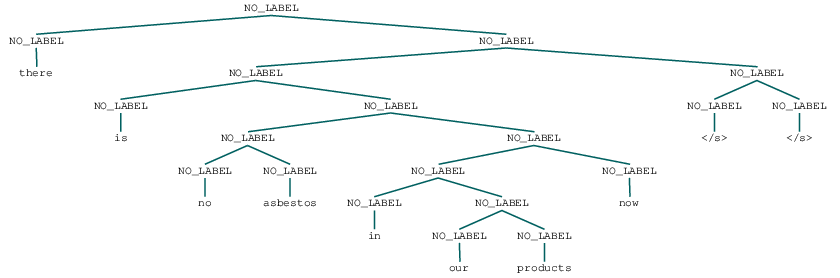

[2 4 3 3 2 1 2 1 0]


In [6]:
#compute the tree formation index for the golden tree
# This does a depth first traversal of tree and gets the left child index of each sub-tree formation

def check_children_availability(tree):
    return len(tree) == 2 # the leaf nodes will have only one children

def get_tree_formation_index(tree, leaves, input_list):
    if(not check_children_availability(tree)):
        # we use the leaves() function to get the indexes of child elements
        # everytime when an element is found, it is important to remove them to avoid getting them reused
        leaveIndex = leaves.index(tree[0])
        leaves[leaveIndex]=''
        return leaveIndex
 
    leftIndex = get_tree_formation_index(tree[0], leaves, input_list)
    rightIndex = get_tree_formation_index(tree[1], leaves, input_list)
    input_list.append(leftIndex)
    return leftIndex

def get_tree_formation_indexes(tree):
    tree_combination= []
    tree_leaves = tree.leaves()
    get_tree_formation_index(tree, tree_leaves, tree_combination)
    
    # the indexes obtained for forming the tree assumes the size of the leaves is unchanged.
    # But everytime when a subtree is formed two nodes are merged together and hence size reduces
    
    # the below code is to make sure the index is updated as according to where the merge happened
    # all the indexes which are right to where the merge happened has to get subtracted by 1 
    # because of removal of a node
    
    for i in range(len(tree_combination)-1):
        for j in range(i+1, len(tree_combination)):
            if(tree_combination[j] > tree_combination[i]):
                tree_combination[j] = tree_combination[j] - 1
    return np.array(tree_combination)

copiedTree = treeDataframe_num.iat[0,1].copy()
display(copiedTree)
tree_formation_indexes = get_tree_formation_indexes(copiedTree)
print(tree_formation_indexes)

In [8]:
print(process.memory_info().rss / (1024*1024), 'MB') # to get memory used by this process in MB

columnList = []
ACT_COL_NAME = 'a'
for i in range(MAX_WORD_COUNT-1):
    columnList.append(ACT_COL_NAME+str(i))
#get the list of indexes and store it in column 'a'. Afterwards break the 'a' to MAX_WORD_COUNT-1 columns
treeDataframe_num[ACT_COL_NAME] = treeDataframe_num['tree'].apply(get_tree_formation_indexes)
treeDataframe_num[columnList] = pd.DataFrame(treeDataframe_num[ACT_COL_NAME].values.tolist(), index= treeDataframe_num.index, dtype=np.int32)
treeDataframe_num.drop(columns=[ACT_COL_NAME], inplace=True)

print(process.memory_info().rss / (1024*1024), 'MB') # to get memory used by this process in MB
print(treeDataframe_num.dtypes)

treeDataframe_num.head()

525.48046875 MB
525.48046875 MB
sentence    object
tree        object
a0           int32
a1           int32
a2           int32
a3           int32
a4           int32
a5           int32
a6           int32
a7           int32
a8           int32
dtype: object


,sentence,tree,a0,a1,a2,a3,a4,a5,a6,a7,a8
0,"[64, 4, 77, 10083, 1, 63, 344, 88, 0, 0]","[[there], [[(NO_LABEL is), (NO_LABEL\n (NO_LA...",2,4,3,3,2,1,2,1,0
1,"[13, 22, 77, 5500, 5, 63, 128, 851, 184, 0]","[[it], [[(NO_LABEL has), (NO_LABEL\n (NO_LABE...",2,5,4,4,3,2,1,1,0
2,"[21117, 1168, 22, 2937, 0, 342, 604, 5, 4763, 0]","[[[cray], [computer]], [[(NO_LABEL has), (NO_L...",0,6,5,4,3,2,1,1,0
3,"[23948, 8, 2855, 6, 16324, 389, 397, 562, 193, 0]","[[esso], [[(NO_LABEL said), (NO_LABEL\n (NO_L...",4,3,5,4,3,2,1,1,0
4,"[29, 788, 84, 342, 478, 491, 821, 6, 833, 0]","[[they], [[(NO_LABEL expect), (NO_LABEL\n (NO...",7,6,5,4,3,2,1,1,0


### Get the subtree set from tree for comparison

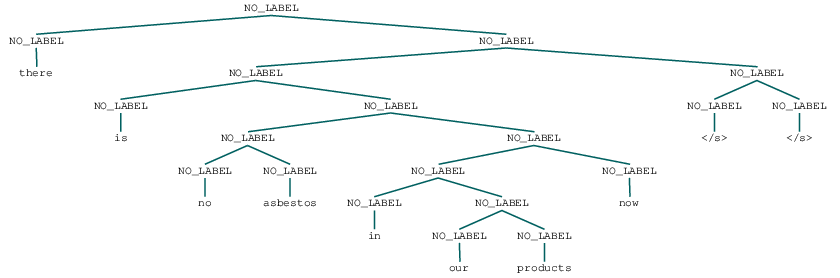

{(2, 7), (4, 7), (4, 6), (5, 6), (8, 9), (2, 3), (1, 9), (1, 7), (0, 9)}
Length: 9


In [9]:
def get_tree_formation_set(tree, leaves, input_set):
    if(not check_children_availability(tree)):
        # we use the leaves() function to get the indexes of child elements
        # everytime when an element is found, it is important to remove them to avoid getting them reused
        leaveIndex = leaves.index(tree[0])
        leaves[leaveIndex]=''
        return (leaveIndex, leaveIndex)
    
    leftIndex = get_tree_formation_set(tree[0], leaves, input_set)
    rightIndex = get_tree_formation_set(tree[1], leaves, input_set)
    new_index = (leftIndex[0], rightIndex[1])
    input_set.add(new_index)
    return new_index

def get_tree_formation_sets(tree):
    tree_combination= set()
    tree_leaves = tree.leaves()
    get_tree_formation_set(tree, tree_leaves, tree_combination)
    
    return tree_combination

copiedTree = treeDataframe_num.iat[0,1].copy()
display(copiedTree)
tree_formation_sets = get_tree_formation_sets(copiedTree)
print(tree_formation_sets)
print('Length:',len(tree_formation_sets))
#{(0, 1), (9, 13), (8, 13), (3, 13), (4, 5), (12, 13), (0, 14), (7, 13), (9, 10), (4, 13), (2, 13), (6, 13), (2, 14), (11, 13)}

In [10]:
print(process.memory_info().rss / (1024*1024), 'MB') # to get memory used by this process in MB

ACT_COL_NAME = 'a'
ACT_SET = ACT_COL_NAME + '_set'
 
#get the list of indexes and store it in column 'a'. Afterwards break the 'a' to MAX_WORD_COUNT-1 columns
treeDataframe_num[ACT_SET] = treeDataframe_num['tree'].apply(get_tree_formation_sets)
print(process.memory_info().rss / (1024*1024), 'MB') # to get memory used by this process in MB
print(treeDataframe_num.dtypes)

treeDataframe_num[['sentence','tree',ACT_SET]].head(n=2)

525.5625 MB
526.1484375 MB
sentence    object
tree        object
a0           int32
a1           int32
a2           int32
a3           int32
a4           int32
a5           int32
a6           int32
a7           int32
a8           int32
a_set       object
dtype: object


,sentence,tree,a_set
0,"[64, 4, 77, 10083, 1, 63, 344, 88, 0, 0]","[[there], [[(NO_LABEL is), (NO_LABEL\n (NO_LA...","{(2, 7), (4, 7), (4, 6), (5, 6), (8, 9), (2, 3..."
1,"[13, 22, 77, 5500, 5, 63, 128, 851, 184, 0]","[[it], [[(NO_LABEL has), (NO_LABEL\n (NO_LABE...","{(6, 7), (4, 8), (2, 8), (5, 7), (1, 8), (2, 3..."


### Form tree from indexes

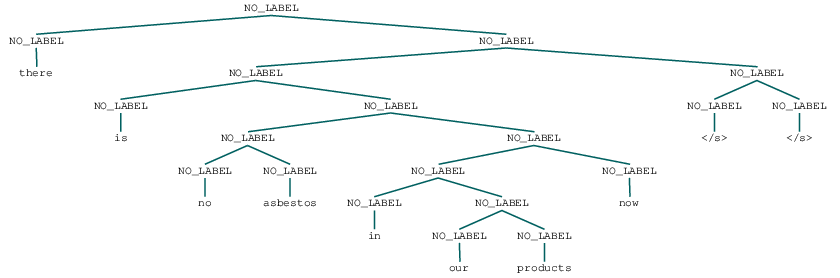

In [11]:
#when the predicted tree combination indexes are figured out, the following funcion will help us to create a
# tree out of it
def form_tree(one_row,colName):
    words = one_row['sentence']
    words = [google_corpus_int_to_word[word] for word in words]
    sub_trees = [nltk.Tree(NO_LABEL,[word]) for word in words]

    for j in range(MAX_WORD_COUNT-1):
        combine_index = one_row[colName+str(j)]
        combine_index = int(combine_index)
        right_tree = sub_trees.pop(combine_index+1)
        left_tree = sub_trees.pop(combine_index)
        sub_trees.insert(combine_index, nltk.Tree(NO_LABEL, [left_tree, right_tree]))
        
    return sub_trees[0]

formed_tree = form_tree(treeDataframe_num.iloc[0], ACT_COL_NAME)
display(formed_tree)

### Custom NLTK tree for doing gradient calculation

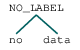

None
2


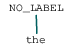

[1, 2, 3, 4, 5, 6, 7, 8, 9, 0]


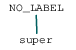

[11, 12, 13, 14, 15, 16, 17, 18, 19, 20]


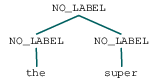

[111, 112, 113, 114, 115, 116, 117, 118, 119, 120]


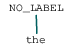

[1, 2, 3, 4, 5, 6, 7, 8, 9, 0]


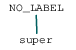

[11, 12, 13, 14, 15, 16, 17, 18, 19, 20]


In [12]:
#the nltk lacks custom data to be shared at node level. 
# the following class extends nltk tree with provision to add custom data
# this is helpful for doing gradient calculation

class extended_nltk_tree(nltk.Tree):
    def __init__(self, label,list_tree, data=None):
        self.data = data
        nltk.Tree.__init__(self,label, list_tree)
        
    def print_with_self_data(self):
        self.print_tree(self)
        
    def print_tree(self,tree):
        display(tree)
        print(tree.data)
        
        if (check_children_availability(tree)) :
            self.print_tree(tree[0])
            self.print_tree(tree[1])

tree = extended_nltk_tree(NO_LABEL,['no','data'])
display(tree)
print(tree.data)
print(len(tree))

tree1 = extended_nltk_tree(NO_LABEL,['the'],[1,2,3,4,5,6,7,8,9,0])
display(tree1)
print(tree1.data)

tree2 = extended_nltk_tree(NO_LABEL,['super'],[11,12,13,14,15,16,17,18,19,20])
display(tree2)
print(tree2.data)

tree = extended_nltk_tree(NO_LABEL,[tree1, tree2],[111,112,113,114,115,116,117,118,119,120])     
tree.print_with_self_data()

In [13]:
treeDF_train, treeDF_test = sklearn.model_selection.train_test_split(treeDataframe_num, test_size=0.2)
#print(treeDF_train.shape)
#print(treeDF_test.shape)

#BREAK_POINT = 200
#treeDF_train = treeDataframe_num.iloc[0:BREAK_POINT]
#treeDF_test = treeDataframe_num.iloc[BREAK_POINT:]

print(treeDF_train.shape)
print(treeDF_test.shape)
display(treeDF_train.head())
display(treeDF_test.head())

(388, 12)
(98, 12)


,sentence,tree,a0,a1,a2,a3,a4,a5,a6,a7,a8,a_set
411,"[3076, 5271, 1308, 9817, 12517, 1310, 48, 778,...","[[[(NO_LABEL toyota), (NO_LABEL (NO_LABEL moto...",2,1,0,1,0,2,2,1,0,"{(6, 9), (1, 3), (4, 5), (2, 3), (0, 5), (0, 9..."
173,"[30, 13, 9817, 1, 125, 253, 3564, 136, 0, 0]","[[but], [[it], [(NO_LABEL\n (NO_LABEL 's)\n ...",4,4,3,3,2,3,2,1,0,"{(2, 7), (4, 6), (2, 9), (4, 5), (8, 9), (1, 9..."
458,"[65, 1569, 4, 6, 395, 3134, 364, 65, 1168, 0]","[[[a], [bus]], [[(NO_LABEL is), (NO_LABEL\n (...",0,3,2,4,3,2,1,1,0,"{(0, 1), (6, 8), (2, 9), (4, 5), (2, 8), (3, 8..."
62,"[28, 3, 1036, 21, 14, 0, 4, 1525, 4862, 0]","[[[who], [(NO_LABEL (NO_LABEL that) (NO_LABEL ...",1,3,2,1,0,2,1,1,0,"{(1, 2), (6, 9), (6, 8), (4, 5), (1, 5), (0, 5..."
162,"[1328, 1599, 269, 10, 13144, 9, 77, 6664, 1225...","[[[*], [(NO_LABEL paying), (NO_LABEL (NO_LABEL...",3,2,1,0,3,2,1,1,0,"{(5, 9), (0, 9), (6, 8), (1, 4), (0, 4), (3, 4..."


,sentence,tree,a0,a1,a2,a3,a4,a5,a6,a7,a8,a_set
439,"[12878, 22, 774, 93, 0, 1599, 24, 3187, 3755, 0]","[[waterford], [[(NO_LABEL has), (NO_LABEL\n (...",7,6,5,4,3,2,1,1,0,"{(6, 8), (4, 8), (2, 8), (3, 8), (1, 8), (1, 9..."
261,"[8715, 4457, 93, 2187, 304, 342, 186, 1, 1786, 0]","[[[(NO_LABEL disciplinary), (NO_LABEL proceedi...",0,1,0,2,3,2,1,1,0,"{(0, 1), (4, 9), (4, 8), (5, 6), (2, 3), (0, 9..."
238,"[1174, 1611, 6, 1749, 2397, 2477, 34, 792, 0, 0]","[[[parts], [(NO_LABEL of), (NO_LABEL\n (NO_LA...",4,3,2,1,0,2,1,1,0,"{(6, 9), (6, 8), (4, 5), (1, 5), (0, 5), (0, 9..."
375,"[1328, 1019, 6, 26216, 0, 152, 648, 446, 11413...","[[*], [[(NO_LABEL\n (NO_LABEL save)\n (NO_LA...",2,1,5,4,3,2,1,1,0,"{(1, 3), (6, 8), (4, 8), (1, 8), (2, 3), (1, 9..."
118,"[1341, 256, 10556, 3, 144, 22, 38, 94, 521, 0]","[[[paper], [companies]], [[(NO_LABEL concede),...",0,6,5,4,3,2,1,1,0,"{(0, 1), (6, 8), (2, 9), (4, 8), (2, 8), (3, 8..."


# Model and the Parameters

In [14]:
def initialize_parameters(layers, param_initial_values=None, word_embeddings=None):
    #layers include the input layer - for which no parameters need to be initialitized. But
    # this information is need to create the first layer parameters
    
    parameters = {}
    
    if param_initial_values is not None:
        assert len(layers) - 1  == len(param_initial_values), ('Length of Arguments mismatch !!!. Layers will include input as extra')
    
    ### TO BE DONE - can check for word embeddings size - need to be half the size of input layer
    #print(layers)
    #print(param_initial_values)

    
    #enumerate from 2nd layer to last layer but one
    i = 1
    for layer in layers[1:len(layers)-1]:
        if param_initial_values is None:
            weight_initial_value = tf.contrib.layers.xavier_initializer(dtype=tf.float64)(shape=(layers[i-1], layers[i]))
            bias_initial_value = tf.contrib.layers.xavier_initializer(dtype=tf.float64)(shape=(1, layers[i]))
        else:
            weight_initial_value = param_initial_values[i-1][0]
            bias_initial_value = param_initial_values[i-1][1]
    
        parameters['w'+str(i)] = tfe.Variable(name='w'+str(i), initial_value=weight_initial_value, dtype=tf.float64)
        parameters['b'+str(i)] = tfe.Variable(name='b'+str(i), initial_value=bias_initial_value, dtype=tf.float64)
        i = i+1
    
    # declare the last layer as score. Val 'i' holds the index for last year
    if param_initial_values is None:
        weight_initial_value = tf.contrib.layers.xavier_initializer(dtype=tf.float64)(shape=(layers[i-1], layers[i]))
        #bias_initial_value = tf.contrib.layers.xavier_initializer(dtype=tf.float64)(shape=(1, layers[i]))
    else:
        weight_initial_value = param_initial_values[i-1][0]
        #bias_initial_value = param_initial_values[i-1][1]

    parameters['wscore'] = tfe.Variable(name='wscore', initial_value=weight_initial_value, dtype=tf.float64)
    #parameters['bscore'] = tfe.Variable(name='bscore', initial_value=bias_initial_value, dtype=tf.float64)
    
    
    if (word_embeddings is not None):
        parameters['embeddings'] = tfe.Variable(name='embeddings', initial_value=word_embeddings.values, 
                                                dtype=tf.float64, trainable=False)
    
    parameters['layers'] = i #exclude the input layer
    
    return parameters

print(initialize_parameters([3,2,1]))
print(initialize_parameters([3,2,1],
                            [[[[1,2],[3,4],[5,6]],[[7,8]]], [[[9],[10]]]]))

{'w1': <tf.Variable 'w1:0' shape=(3, 2) dtype=float64, numpy=
array([[-0.39835226, -0.72644738],
       [-0.33062902,  0.76953716],
       [ 0.83786498, -1.09178997]])>, 'b1': <tf.Variable 'b1:0' shape=(1, 2) dtype=float64, numpy=array([[1.00604845, 0.76373517]])>, 'wscore': <tf.Variable 'wscore:0' shape=(2, 1) dtype=float64, numpy=
array([[0.90982633],
       [0.02250334]])>, 'layers': 2}
{'w1': <tf.Variable 'w1:0' shape=(3, 2) dtype=float64, numpy=
array([[1., 2.],
       [3., 4.],
       [5., 6.]])>, 'b1': <tf.Variable 'b1:0' shape=(1, 2) dtype=float64, numpy=array([[7., 8.]])>, 'wscore': <tf.Variable 'wscore:0' shape=(2, 1) dtype=float64, numpy=
array([[ 9.],
       [10.]])>, 'layers': 2}


In [15]:
parametersPath = os.path.join(dirname, 'parameters/')
with open(parametersPath+'parameters_latest.pic', 'rb') as pickle_file:    
    parameters_load = pickle.load(pickle_file)

In [54]:
def embedding_lookup(input_words, parameters):
    wordsEmbeddings = tf.nn.embedding_lookup(parameters['embeddings'], input_words)
    return wordsEmbeddings


init_param = initialize_parameters([2*STATE_SIZE,STATE_SIZE,1], word_embeddings=googleVectors)
print(UNK)
print(embedding_lookup(google_corpus_word_to_int[UNK], init_param))
print([UNK])
print(embedding_lookup([google_corpus_word_to_int[UNK]], init_param))
print(FILLER)
print(embedding_lookup(google_corpus_word_to_int[FILLER], init_param))


</s>
tf.Tensor(
[ 1.1291504e-03 -8.9645386e-04  3.1852722e-04  1.5335083e-03
  1.1062622e-03 -1.4038086e-03 -3.0517578e-05 -4.1961670e-04
 -5.7601930e-04  1.0757446e-03 -1.0223389e-03 -6.1798096e-04
 -7.5531006e-04  1.4038086e-03 -1.6403198e-03 -6.3323975e-04
  1.6326904e-03 -1.0070801e-03 -1.2664795e-03  6.5231323e-04
 -4.1580200e-04 -1.0757446e-03  1.5258789e-03 -2.7465820e-04
  1.4019012e-04  1.5716553e-03  1.3580322e-03 -8.3160400e-04
 -1.4038086e-03  1.5792847e-03], shape=(30,), dtype=float64)
['</s>']
tf.Tensor(
[[ 1.1291504e-03 -8.9645386e-04  3.1852722e-04  1.5335083e-03
   1.1062622e-03 -1.4038086e-03 -3.0517578e-05 -4.1961670e-04
  -5.7601930e-04  1.0757446e-03 -1.0223389e-03 -6.1798096e-04
  -7.5531006e-04  1.4038086e-03 -1.6403198e-03 -6.3323975e-04
   1.6326904e-03 -1.0070801e-03 -1.2664795e-03  6.5231323e-04
  -4.1580200e-04 -1.0757446e-03  1.5258789e-03 -2.7465820e-04
   1.4019012e-04  1.5716553e-03  1.3580322e-03 -8.3160400e-04
  -1.4038086e-03  1.5792847e-03]], shape=(

In [55]:
def neural_network_pass(batch_data, selection, batch_result_set, col_name, parameters, hyper_parameters):
    
    PRINT_INFO = False
    if PRINT_NN_PASS_DEBUG in hyper_parameters:
        PRINT_INFO = hyper_parameters[PRINT_NN_PASS_DEBUG]
    
    assert (selection == 'max' or selection == 'choose'), ('Selection have to be either max or choose')
    #batch_result_set = pd.DataFrame(batch_data, index=data.index)

    # get the word vectors - its shape will be (no. of sentence, no.of words, no. of states)
    embedding_data = embedding_lookup(batch_data['sentence'], parameters)
    if(PRINT_INFO):
        print('Embedding data : ', embedding_data)
    
    BATCH_SIZE = embedding_data.shape[0] 
    NO_OF_WORDS = embedding_data.shape[1]
    STATE_SIZE = embedding_data.shape[2]
    if(PRINT_INFO):
        print('Batch size : ',BATCH_SIZE,'No. of words : ',NO_OF_WORDS,'State size : ',STATE_SIZE)
    
    total_score = tf.zeros((BATCH_SIZE,1), dtype=tf.float64)
    
    sval_list = []   
    for i in batch_result_set.index:
        sval_list.append({})
     
    # enumerate through all the word combinations
    # find the best combination, replace with respective two word combination
    # do it untill only one word is present
    #print('------------'+col_name+'-------------------')
    for word_counter in range(NO_OF_WORDS-1):
        
        # concatenate the word combinations - first data will contain 1st to n-1th word and 
        # second data will contain 2nd to nth word
        first_data = tf.slice(embedding_data, [0,0,0], [BATCH_SIZE, NO_OF_WORDS-1, STATE_SIZE])
        second_data = tf.slice(embedding_data, [0,1,0], [BATCH_SIZE, NO_OF_WORDS-1, STATE_SIZE])
        concatenated_data = tf.concat([first_data, second_data], axis=2)
        reshaped_data = tf.reshape(concatenated_data, (-1,2*STATE_SIZE))
        if(PRINT_INFO):
            print('Reshaped Embedded data : ', reshaped_data)
        
        layers = parameters['layers']
        temp_data = reshaped_data
        for i in range(1,layers): # enumerate leaves the input and output layer
            w = parameters['w'+str(i)]
            b = parameters['b'+str(i)]
            # applying linear and non-linear transformation to output STATE_SIZE dimensions
            # this becomes the representation vector for phrases
            temp_data = tf.tanh(tf.matmul(temp_data, w) + b)
        output_data = temp_data
        if(PRINT_INFO):
            print('Output data : ', output_data)

        # compute score of the above transformation to rank them
        w_score = parameters['wscore']
        scored_data = tf.matmul(output_data, w_score)
        reshaped_scored_data = tf.reshape(scored_data, (BATCH_SIZE,-1,1))
        if(PRINT_INFO):
            print('Scored data : ', scored_data)
        
        # get the list of indexes whose scores are high
        if(selection == 'max'):
            argmax_score = tf.argmax(reshaped_scored_data, axis=1, output_type=tf.int32)
            squeeze_argmax_score = tf.squeeze(argmax_score)
            batch_result_set.loc[batch_data.index, col_name+str(word_counter)] = squeeze_argmax_score.numpy().astype(int).tolist()
        # if it is actual tree then take the score respective to actual ones
        elif(selection == 'choose'):
            argmax_score = tf.convert_to_tensor(batch_data[col_name+str(word_counter)], dtype=tf.int32)
            argmax_score = tf.reshape(argmax_score, shape=(argmax_score.shape[0], 1))
            squeeze_argmax_score = tf.squeeze(argmax_score)
        if(PRINT_INFO):
            print('Argmax Scored data : ', squeeze_argmax_score)
        
        # convert the indexing to support reshaping of 2D matrix. this is important to
        # remove the word  vector at argmax position with arrays having NO_OF_WORDS size
        range_data = (tf.range(0, BATCH_SIZE) * (NO_OF_WORDS))
        range_data = tf.reshape(range_data, (BATCH_SIZE,1))
        range_data = range_data + argmax_score
        range_data_list = tf.squeeze(range_data).numpy().tolist()
        if(type(range_data_list) != list):
            range_data_list = [range_data_list]
        if(PRINT_INFO):
            print('Range data : ', range_data)
        
        # remove the word  vector at argmax position with arrays having NO_OF_WORDS-1 size
        range_data_minus = (tf.range(0, BATCH_SIZE) * (NO_OF_WORDS-1))
        range_data_minus = tf.reshape(range_data_minus, (BATCH_SIZE,1))
        range_data_minus = range_data_minus + argmax_score
        range_data_minus_list = tf.squeeze(range_data_minus).numpy().tolist()
        if(type(range_data_minus_list) != list):
            range_data_minus_list = [range_data_minus_list]
        if(PRINT_INFO):
            print('Range data minus : ', range_data_minus)
        
        max_scored_data = tf.gather(scored_data, range_data_minus)
        squeezed_max_score = tf.squeeze(max_scored_data)
        squeezed_max_score = tf.reshape(squeezed_max_score,
                                        shape=(-1, 1))
        total_score = tf.add(total_score, squeezed_max_score)
        if(PRINT_INFO):
            print('Max Scored data : ', squeezed_max_score)
        
        # 1) Remove the first of two words from data which got the maximum score for the combination
        # 2) Replace the second word with the combined phrase representation
        # 3) The no. of words in the sentence will be reduced by 1
        
        # 1) Remove the first of two words from data which got the maximum score for the combination        
        max_ouput_data = tf.gather(output_data, range_data_minus)
        squeezed_max_ouput = tf.squeeze(max_ouput_data)
        squeezed_max_ouput = tf.reshape(squeezed_max_ouput,
                                        shape=(BATCH_SIZE, -1, 1))
        unstacked_max_output = tf.unstack(squeezed_max_ouput)
        if(PRINT_INFO):
            print('Unstacked squeezed max output : ', unstacked_max_output)
        
        j = 0
        for i in batch_result_set.index:
            sval_list[j][word_counter] = unstacked_max_output[j]
            j = j + 1

        # create a bool list with true values of size sentences*words
        # replace the values at argmax position with false
        bool_mask_data = [True] * (BATCH_SIZE*NO_OF_WORDS)
        for i in range_data_list:
            bool_mask_data[i] = False
        if(PRINT_INFO):
            print('Boolean mask data : ', bool_mask_data)
        
        # use the boolean mask to filter the rows (axis=0)
        reshaped_data = tf.reshape(embedding_data, (-1,STATE_SIZE))
        if(PRINT_INFO):
            print('Reshaped data : ', reshaped_data)

        reshaped_new_data = tf.boolean_mask(reshaped_data, bool_mask_data, axis=0)
        if(PRINT_INFO):
            print('Reshaped new data : ', reshaped_new_data)
        
        # 2) Replace the second word with the combined phrase representation
        
        # replace the input words with phrase vectors at argmax position(bool mask data)
        bool_mask_data = [True] * (BATCH_SIZE*(NO_OF_WORDS-1))
        for i in range_data_minus:
            bool_mask_data[i] = False
        if(PRINT_INFO):
            print('Boolean mask data : ', bool_mask_data)
        embedding_data = tf.where(bool_mask_data, reshaped_new_data, output_data)
        embedding_data = tf.reshape(embedding_data,shape=(BATCH_SIZE, -1, STATE_SIZE))
        
        if(PRINT_INFO):
            print('Embedding data : ', embedding_data)
        # 3) The no. of words in the sentence will be reduced by 1
        NO_OF_WORDS = embedding_data.shape[1]
        if(PRINT_INFO):
            print('No. of words : ', NO_OF_WORDS)
    batch_result_set.loc[batch_data.index, col_name+'_sval_list'] = sval_list
    if(PRINT_INFO):
        print(' Sval list : ',sval_list)
    batch_result_set.loc[batch_data.index, col_name+'_score'] = total_score
    if(PRINT_INFO):
        print('Total score : ', total_score)

PREDICT_COL_NAME = 'p'
PREDICT_SET = PREDICT_COL_NAME + '_set'
PRINT_NN_PASS_DEBUG = 'PRINT_NN_PASS_DEBUG'
hyper_parameters = {PRINT_NN_PASS_DEBUG:True}
'''
parameters = initialize_parameters([2*STATE_SIZE,STATE_SIZE,1], word_embeddings=googleVectors)
print('Parameters - ', parameters)
batch_result_set = pd.DataFrame(treeDF_train, index=treeDF_train.index)
print('-------------predict---------------')
neural_network_pass(treeDF_train, 'max', batch_result_set, 
                                           PREDICT_COL_NAME, parameters, hyper_parameters)
print('-------------actual---------------')
neural_network_pass(treeDF_train, 'choose', batch_result_set, 
                                           ACT_COL_NAME, parameters, hyper_parameters)
display(batch_result_set)
'''

# for manual gradient calculation, we need to store the transformed values at every combination
# we create a tree from combination list and also the sval list stored accordingly
def form_tree_with_sval(one_row,colName,sval_list_name, parameters, hyper_parameters={}):
    PRINT_INFO = False
    #if PRINT_TREE_SVAL_DEBUG in hyper_parameters:
    #    PRINT_INFO = hyper_parameters[PRINT_TREE_SVAL_DEBUG]
        
    numbers = one_row['sentence']
    sval_list = one_row[sval_list_name]
    #print(sval_list)
    #get the words from indexes and create a tree of all leaf nodes
    #words = [google_corpus_int_to_word[num] for num in numbers]
    sub_trees = [extended_nltk_tree(NO_LABEL,[google_corpus_int_to_word[num]], tf.reshape(embedding_lookup([num], parameters), (STATE_SIZE,1) )) for num in numbers]
    
    #for num in numbers:
    #    print('Wordval : ', embedding_lookup([num], parameters))
    
    for j in range(MAX_WORD_COUNT-1):
        combine_index = one_row[colName+str(j)]
        combine_index = int(combine_index)
        #only the left index is stored in combination index
        # pop the n+1th element, nth element and replace the combination at nth index
        right_tree = sub_trees.pop(combine_index+1)
        left_tree = sub_trees.pop(combine_index)
        #print('Sval : ',sval_list[j])
        sub_trees.insert(combine_index, extended_nltk_tree(NO_LABEL, [left_tree, right_tree], sval_list[j]))
        
    return sub_trees[0]

#PRINT_TREE_SVAL_DEBUG = 'PRINT_TREE_SVAL_DEBUG'
#hyper_parameters = {PRINT_NN_PASS_DEBUG:True} #{} #{PRINT_NN_PASS_DEBUG:False}
#result_tree = form_tree_with_sval(batch_result_set.iloc[0], PREDICT_COL_NAME, PREDICT_COL_NAME+'_sval_list', parameters)
#result_tree.print_with_self_data()
#result_tree = form_tree_with_sval(batch_result_set.iloc[0], ACT_COL_NAME, ACT_COL_NAME+'_sval_list', parameters)
#result_tree.print_with_self_data()

def compare_trees_row_using_set(one_row):
    actual = one_row[ACT_SET]
    predict = one_row[PREDICT_SET]
    
    common = len(predict.intersection(actual)) - 1 # root needs to be removed - sometimes we dont do it
    total = len(predict) - 1 # root needs to be removed - sometimes we dont do it
    #print('common:', common, ', total:', total)
    return (common/total) * 100

#result_same = compare_trees_row_using_set(batch_result_set.iloc[0])
#print('% of match:',result_same)

def compare_trees_row_using_set_for_diff(one_row):
    actual = one_row[ACT_SET]
    predict = one_row[PREDICT_SET]
    diff = len(predict.difference(actual))
    return diff

#result_diff = compare_trees_row_using_set_for_diff(batch_result_set.iloc[0])
#print('Count of diff:',result_same)

PRINT_FWD_PASS_DEBUG = 'PRINT_FWD_PASS_DEBUG'
def one_forward_pass(batch_data, parameters, hyper_parameters):
    PRINT_INFO = False
    if PRINT_FWD_PASS_DEBUG in hyper_parameters:
        PRINT_INFO = hyper_parameters[PRINT_FWD_PASS_DEBUG]

    batch_result_set = pd.DataFrame(batch_data, index=batch_data.index)
    
    neural_network_pass(batch_data, 'max', batch_result_set, 
                                           PREDICT_COL_NAME, parameters, hyper_parameters)
    neural_network_pass(batch_data, 'choose', batch_result_set, 
                                        ACT_COL_NAME, parameters, hyper_parameters)

    batch_result_set['predict'] = batch_result_set.apply(form_tree_with_sval,
                                                 args=(PREDICT_COL_NAME, PREDICT_COL_NAME+'_sval_list', parameters),
                                                 axis=1)
    batch_result_set[PREDICT_SET] = batch_result_set['predict'].apply(get_tree_formation_sets)

    batch_result_set['actual'] = batch_result_set.apply(form_tree_with_sval,
                                                args=(ACT_COL_NAME, ACT_COL_NAME+'_sval_list', parameters),
                                                axis=1)
    batch_result_set['accuracy'] = batch_result_set.apply(compare_trees_row_using_set,axis=1)
    batch_result_set['diff'] = batch_result_set.apply(compare_trees_row_using_set_for_diff,axis=1)

    return batch_result_set


'''
hyper_parameters = {}#{PRINT_FWD_PASS_DEBUG:True}
parameters = initialize_parameters([2*STATE_SIZE,STATE_SIZE,1], word_embeddings=googleVectors)
batch_result_set = one_forward_pass(treeDF_train, parameters, hyper_parameters)
display(batch_result_set)
'''

'\nhyper_parameters = {}#{PRINT_FWD_PASS_DEBUG:True}\nparameters = initialize_parameters([2*STATE_SIZE,STATE_SIZE,1], word_embeddings=googleVectors)\nbatch_result_set = one_forward_pass(treeDF_train, parameters, hyper_parameters)\ndisplay(batch_result_set)\n'

In [56]:
# it calculates the gradient of each paramters with respect to one tree and adds to already available gradient
def calculate_gradient_tree(tree, parameters, gradients, error=None):
    #All the high level nodes except the leaf is given a data.
    # leaf is the node with a single word
    # check whether the left and right node has data
    
    PRINT_INFO = False
    #if PRINT_FWD_PASS_DEBUG in hyper_parameters:
    #    PRINT_INFO = hyper_parameters[PRINT_FWD_PASS_DEBUG]

    is_left_available = (tree[0].data != None)
    is_right_available = (tree[1].data != None)
    
    # if both are available then process it, otherwise traverse accordingly
    if(is_left_available and is_right_available):
    
        # it is expected that the gradients are in right shape. column vector x * 1
        gradients['dwscore'] = tf.add(gradients['dwscore'], tree.data)

        delta = parameters['wscore']
        if error is not None:
            delta = tf.add(delta, error)

        one_data = tf.ones_like(tree.data)
        square_data = tf.square(tree.data)
        tanh_diff = tf.subtract(one_data, square_data)
        #print(one_data.shape, square_data.shape, tanh_diff.shape)

        delta = tf.multiply(delta, tanh_diff)
        delta_transpose = tf.transpose(delta)
        gradients['db1'] = tf.add(gradients['db1'], delta_transpose)

        #print(delta.shape, delta_transpose.shape, gradients['db'].shape)

        concatenated_data = tf.concat([tree[0].data, tree[1].data], axis=0)
        concatenated_data = tf.reshape(concatenated_data, shape=(concatenated_data.shape[0], 1))

        #print(concatenated_data.shape)
        gradient_dw = tf.matmul(concatenated_data, delta , transpose_b=True)
        gradients['dw1'] = tf.add(gradients['dw1'], gradient_dw)
        #print(concatenated_data.shape, gradient_dw.shape, gradients['dw'].shape)

        
        error = tf.matmul(delta, parameters['w1'], transpose_a=True, transpose_b=True)
        error = tf.transpose(error)
        left_error = error[0:tree.data.shape[0]]
        right_error = error[tree.data.shape[0]:]
        #print(left_error.shape, right_error.shape)

        #print(gradients['dw_score'].shape)
        calculate_gradient_tree(tree[0], parameters, gradients, left_error)
        calculate_gradient_tree(tree[1], parameters, gradients, right_error)
    elif is_left_available:
        calculate_gradient_tree(tree[0], parameters, gradients, error)
    elif is_right_available:
        calculate_gradient_tree(tree[1], parameters, gradients, error)
        

    return None

In [57]:
# it calculates the gradient of each paramters with respect to one tree and adds to already available gradient
def calculate_gradient_tree_another_method(tree, parameters, hyper_parameters, gradients, error=None):
    #All the high level nodes except the leaf is given a data.
    # leaf is the node with a single word
    # check whether the left and right node has data
    
    #is_left_available = (tree[0].data != None)
    #is_right_available = (tree[1].data != None)
    
    #print(tree)
    #print(len(tree))

    #is_left_available = (type(tree[0]) != type('a string'))
    #is_right_available = (type(tree[1]) != type('a string'))
    
    #if(len(tree) > 1):
    #    print('Left and Right available')
    #else:
    #    print('Only one children available')
    #print('Left Available - ', is_left_available,', Right Available - ', is_right_available)

    '''
    if error is not None:
        print('error shape:',error.shape)
        
    parameter_names = ['w1','b1','wscore','bscore']
    for name in parameter_names:
        print(name+' shape:', parameters[name].shape)
        
    gradient_names = ['dw1', 'db1', 'dwscore', 'dbscore']
    for name in gradient_names:
        print(name+' shape:', gradients[name].shape)

    print('Tree data shape:',tree.data.shape)
    
    
    Delta shape (1, 10)
gradients db1 shape (1, 10)
concatenated data shape (20, 1)
gradients dw1 shape (20, 10)
final error shape (20, 1)
left error shape (10, 1)
right error shape (10, 1)
initial error shape: (10, 1)
Delta shape (10, 10)
gradients db1 shape (10, 10)
concatenated data shape (20, 1)
    '''
    
    # if both are available then process it, otherwise traverse accordingly
    #if(is_left_available and is_right_available):
    #if(len(tree) > 1):
    
    PRINT_INFO = False
    if PRINT_GRD_CALC_DEBUG in hyper_parameters:
        PRINT_INFO = hyper_parameters[PRINT_GRD_CALC_DEBUG]
    
    if(PRINT_INFO):
        display(tree)
    
    if(check_children_availability(tree)):
        if(PRINT_INFO):
            print('Both trees available : ', tree.label())
            print('Tree data : ', tree.data)
        # it is expected that the gradients are in right shape. column vector x * 1
        gradients['dwscore'] = tf.add(gradients['dwscore'], tree.data)

        one_data = tf.ones_like(tree.data)
        square_data = tf.square(tree.data)
        tanh_diff = tf.subtract(one_data, square_data)
        
        if(PRINT_INFO):
            print('Tanh diff data', tanh_diff)

        delta = parameters['wscore']
        delta = tf.multiply(delta, tanh_diff)
        if error is not None:
            if(PRINT_INFO):
                print('initial error data:',error)
            delta = tf.add(delta, error)
        delta = tf.transpose(delta)
        if(PRINT_INFO):
            print('Delta data : ',delta)

        gradients['db1'] = tf.add(gradients['db1'], delta)
        #print('gradients db1 shape', gradients['db1'].shape)

        #print('tree0 shape : ',tree[0].data.shape,' tree1 shape : ', tree[1].data.shape)
        concatenated_data = tf.concat([tree[0].data, tree[1].data], axis=0)
        concatenated_data = tf.reshape(concatenated_data, shape=(concatenated_data.shape[0], 1))

        gradient_dw = tf.matmul(concatenated_data, delta)
        gradients['dw1'] = tf.add(gradients['dw1'], gradient_dw)
        #print('gradients dw1 shape', gradients['dw1'].shape)

        error = tf.matmul(delta, parameters['w1'], transpose_b=True)
        error = tf.transpose(error)
        #print('final error shape', error.shape)

        left_error = error[0:tree.data.shape[0]]
        right_error = error[tree.data.shape[0]:]

        one_data = tf.ones_like(tree[0].data)
        square_data = tf.square(tree[0].data)
        left_tanh = tf.subtract(one_data, square_data)
        left_error = tf.multiply(left_error, left_tanh)
        ##print('left error shape', left_error.shape)


        one_data = tf.ones_like(tree[1].data)
        square_data = tf.square(tree[1].data)
        right_tanh = tf.subtract(one_data, square_data)
        right_error = tf.multiply(right_error, right_tanh)
        ##print('right error shape', right_error.shape)
        
        calculate_gradient_tree_another_method(tree[0], parameters, hyper_parameters, gradients, left_error)
        calculate_gradient_tree_another_method(tree[1], parameters, hyper_parameters, gradients, right_error)
    else:
        if(PRINT_INFO):
            print('No children available !!!')
    #else:
    #    calculate_gradient_tree_another_method(tree[0], parameters, gradients, error)
    
    #elif is_left_available:
    #    calculate_gradient_tree_another_method(tree[0], parameters, gradients, error)
    #elif is_right_available:
    #    calculate_gradient_tree_another_method(tree[1], parameters, gradients, error)
        

    return None

PRINT_GRD_CALC_DEBUG = 'PRINT_GRD_CALC_DEBUG'

In [58]:
def compute_loss(batch_result_set, parameters, hyper_parameters):
    
    l2_rate = hyper_parameters[L2_RATE]
    tree_loss_rate = hyper_parameters[TREE_LOSS_RATE]
    
    batch_predict_score = batch_result_set[PREDICT_COL_NAME+'_score']
    batch_actual_score = batch_result_set[ACT_COL_NAME+'_score']
    
    losses = tf.subtract(batch_predict_score, batch_actual_score) #+ (tree_loss_rate*batch_result_set['diff'])
    #losses = batch_predict_score

    sum_square_weights =  0.0
    for i in range(1, parameters['layers']):
        sum_square_weights = sum_square_weights + tf.reduce_sum(tf.square(parameters['w'+str(i)]))
    sum_square_weights = sum_square_weights + tf.reduce_sum(tf.square(parameters['wscore']))
    sum_square_weights = sum_square_weights / 2

    avg_loss = tf.reduce_mean(losses).numpy()  
    avg_loss = avg_loss + (l2_rate * sum_square_weights) #L2
    
    return avg_loss, losses

def one_backward_pass(tape, batch_result_set, parameters, hyper_parameters):
    
    PRINT_INFO = False
    if PRINT_BACK_PASS_DEBUG in hyper_parameters:
        PRINT_INFO = hyper_parameters[PRINT_BACK_PASS_DEBUG]

    parameter_list = []
    
    avg_loss, losses = compute_loss(batch_result_set, parameters, hyper_parameters)
    
    for i in range(1,parameters['layers']):
        parameter_list.append(parameters['w'+str(i)])
        parameter_list.append(parameters['b'+str(i)])
    parameter_list.append(parameters['wscore'])
    #parameter_list.append(parameters['bscore'])
    
    
    if(tape != None):
        grads = tape.gradient(avg_loss, parameter_list)
        #grad_op = optimizer.apply_gradients(zip(grads, parameter_list), 
        #                      global_step=tf.train.get_or_create_global_step())
    else:
        
        gradients_predict = {}
        gradients_actual = {}
        for i in range(1,parameters['layers']):
            gradients_predict['dw'+str(i)] = tf.zeros_like(parameters['w'+str(i)])
            gradients_predict['db'+str(i)] = tf.zeros_like(parameters['b'+str(i)])
            
            gradients_actual['dw'+str(i)] = tf.zeros_like(parameters['w'+str(i)])
            gradients_actual['db'+str(i)] = tf.zeros_like(parameters['b'+str(i)])
        gradients_predict['dwscore'] = tf.zeros_like(parameters['wscore'])
        #gradients_predict['dbscore'] = tf.zeros_like(parameters['bscore'])
        
        gradients_actual['dwscore'] = tf.zeros_like(parameters['wscore'])
        #gradients_actual['dbscore'] = tf.zeros_like(parameters['bscore'])
        
        if(PRINT_INFO):
            print('--------------predict-------------------')
        batch_result_set['predict'].apply(calculate_gradient_tree_another_method, args=(parameters, 
                                                                                        hyper_parameters, 
                                                                                        gradients_predict))
        if(PRINT_INFO):
            print('--------------actual-------------------')
        batch_result_set['actual'].apply(calculate_gradient_tree_another_method, args=(parameters, 
                                                                                       hyper_parameters,
                                                                                       gradients_actual))
        
        #print('Gradient predict : ',gradients_predict)
        #print('Gradient actual : ',gradients_actual)

        #dw1 = gradients_predict['dw1']
        #db1 = gradients_predict['db1']
        #dwscore = gradients_predict['dwscore']
        
        dw1 = tf.subtract(gradients_predict['dw1'], gradients_actual['dw1'])
        db1 = tf.subtract(gradients_predict['db1'], gradients_actual['db1'])
        dwscore = tf.subtract(gradients_predict['dwscore'], gradients_actual['dwscore'])
        #dbscore = tf.subtract(gradients_predict['dbscore'], gradients_actual['dbscore']) # which is zero always
        
        #print(dwscore)
        l2_rate = hyper_parameters[L2_RATE]
        dw1 = tf.divide(dw1,batch_result_set.shape[0]) + l2_rate * parameters['w1']
        db1 = tf.divide(db1,batch_result_set.shape[0]) #+ l2_rate * parameters['b1']
        dwscore = tf.divide(dwscore,batch_result_set.shape[0]) + l2_rate * parameters['wscore']
        ##dbscore = tf.divide(dbscore,batch_result_set.shape[0]) + #l2_rate * parameters['bscore']
        #print(dwscore)
        grads = [dw1, db1, dwscore]
        #grads = [dwscore]
        
        #grad_op = optimizer.apply_gradients(zip([dw1,db1,dwscore,dbscore], parameter_list), 
        #                      global_step=tf.train.get_or_create_global_step())
         
    return avg_loss, tf.reduce_sum(losses), parameter_list, grads

PRINT_BACK_PASS_DEBUG = 'PRINT_BACK_PASS_DEBUG'

In [59]:
BATCH_SIZE = 'batch_size'
EPOCH = 'epoch'
DELTA = 'delta'
LEARNING_RATE = 'learning_rate'
L2_RATE = 'l2_rate'
TREE_LOSS_RATE = 'tree_loss_rate'

def gradient_check(data, parameters, hyper_parameters):
    
    PRINT_INFO = False
    if PRINT_GRAD_CHECK_DEBUG in hyper_parameters:
        PRINT_INFO = hyper_parameters[PRINT_GRAD_CHECK_DEBUG]
        
    batch_size = hyper_parameters[BATCH_SIZE]
    data_size = data.shape[0]
    batch_count = int(math.ceil(data_size/batch_size))
    epoch_count = hyper_parameters[EPOCH] 
    optimizer_learn_rate = hyper_parameters[LEARNING_RATE]
    delta_val = hyper_parameters[DELTA]
    
    start_memory = process.memory_info().rss
    start_time = timer()
    
    tape = None
    #with tf.GradientTape() as tape:
    
    batch_data = data
    #print(batch_data)

    batch_result_set = one_forward_pass(batch_data, parameters, hyper_parameters)
    batch_avg_accuracy = np.average(batch_result_set['accuracy'])

    batch_avg_loss, batch_sum_loss, parameter_list, grads = one_backward_pass(tape,  
                                                                              batch_result_set, 
                                                                              parameters, 
                                                                              hyper_parameters)
    grad_approximate_dict = {}
    grad_dict = {}
    keyword_list = ['w1','b1','wscore']
    for i in range(len(keyword_list)):
        keyword = keyword_list[i]
        grad_dict[keyword] = grads[i]
        grad_approximate_dict[keyword] = np.zeros_like(grads[i].numpy())
        delta_zero = np.zeros_like(grad_dict[keyword].numpy())
        
        for j in range(parameters[keyword].shape[0]):
            for k in range(parameters[keyword].shape[1]):

                print(keyword,' - ',j,':',k)

                if(PRINT_INFO):
                    print(keyword,' - ', j,':',k)
                    print(parameters[keyword])
                delta_zero[j,k] = delta_val
                if(PRINT_INFO):
                    print(delta_zero)
                parameters[keyword] = parameters[keyword] + delta_zero
                if(PRINT_INFO):
                    print(parameters[keyword])
                
                batch_result_plus_set = one_forward_pass(batch_data, parameters, hyper_parameters)
                plus_avg_loss,_ = compute_loss(batch_result_plus_set, parameters, hyper_parameters)

                #print(plus_avg_loss)
                
                parameters[keyword] = parameters[keyword] - delta_zero
                if(PRINT_INFO):
                    print(parameters[keyword])
                parameters[keyword] = parameters[keyword] - delta_zero
                if(PRINT_INFO):
                    print(parameters[keyword])
                
                batch_result_minus_set = one_forward_pass(batch_data, parameters, hyper_parameters)
                minus_avg_loss,_ = compute_loss(batch_result_minus_set, parameters, hyper_parameters)

                #print(minus_avg_loss)
                
                grad_approximate_dict[keyword][j, k] =  (plus_avg_loss - minus_avg_loss) / (2*delta_val)
                if(PRINT_INFO):
                    print(plus_avg_loss, minus_avg_loss)
                
                parameters[keyword] = parameters[keyword] + delta_zero
                if(PRINT_INFO):
                    print(parameters[keyword])
                
                delta_zero[j,k] = 0
                if(PRINT_INFO):
                    print(delta_zero)
                    
                stop_memory = process.memory_info().rss
                stop_time = timer()
                print('Time taken (sec) : ', stop_time - start_time)

                
    stop_memory = process.memory_info().rss
    stop_time = timer()
    
    #print('Time taken (sec) : ', stop_time - start_time)
    #print('Memory consumed (MB) : ', (stop_memory - start_memory) /(1024*1024))
    
    return grad_dict, grad_approximate_dict

PRINT_GRAD_CHECK_DEBUG = 'PRINT_GRAD_CHECK_DEBUG'
hyper_parameters = {
    BATCH_SIZE : 1024,
    EPOCH : 1,
    LEARNING_RATE : 0.001,
    L2_RATE : 0.001,
    TREE_LOSS_RATE : 0.1,
    #PRINT_GRAD_CHECK_DEBUG : True,
    PRINT_GRD_CALC_DEBUG:False,
    PRINT_BACK_PASS_DEBUG:False,
    DELTA : 1e-7#0.0000001#0.0001#0.00000001#0.1#
}

TOTAL_RUN_COUNT = 5
gradient_check_right_count = 0
for i in range(TOTAL_RUN_COUNT):
    parameters = initialize_parameters([2*STATE_SIZE,STATE_SIZE,1], word_embeddings=googleVectors)
    grads, grads_approximate = gradient_check(treeDF_train, parameters, hyper_parameters)
    #print(grads, grads_approximate)
    keywords = ['w1','b1','wscore']
    sum_diff_square = 0.0
    sum_square = 0.0
    sum_approximate_square = 0.0

    for keyword in keywords:
        diff_vector = grads[keyword]-grads_approximate[keyword]
        diff_square = np.sum(np.square(diff_vector))
        sum_diff_square = sum_diff_square + diff_square
        
        square = np.sum(np.square(grads[keyword]))
        sum_square = sum_square + square
        
        approximate_square = np.sum(np.square(grads_approximate[keyword]))
        sum_approximate_square = sum_approximate_square + approximate_square

        denominator_sum = square + approximate_square
        '''
        if(denominator_sum == 0.0):
            print(keyword+' Gradient check : 0.0')
        else:
            print(keyword+' Gradient check : ',math.sqrt(diff_square) / (math.sqrt(square) + math.sqrt(approximate_square)))
        '''
    #print(sum_diff_square, sum_square, sum_approximate_square)
    gradient_check_val = math.sqrt(sum_diff_square) / (math.sqrt(sum_square) + math.sqrt(sum_approximate_square))
    if(gradient_check_val <= hyper_parameters[DELTA]):
        gradient_check_right_count = gradient_check_right_count + 1
    print(i+1,') Total Gradient check : ',gradient_check_val)
    
    print('No. of times gradient check is right - ', gradient_check_right_count,' out of ', i+1)
print('No. of times gradient check is right - ', gradient_check_right_count,' out of ', TOTAL_RUN_COUNT)
    

#print('Gradient check check :-) : ', np.linalg.norm(grads[keyword]-grads_approximate[keyword])/(np.linalg.norm(grads[keyword]) + np.linalg.norm(grads_approximate[keyword])))
#print(i+1,' : '+keyword+' check : ', np.linalg.norm(grads[keyword]-grads_approximate[keyword])/(np.linalg.norm(grads[keyword]) + np.linalg.norm(grads_approximate[keyword])))
      

w1  -  0 : 0
Time taken (sec) :  12.791171207998559
w1  -  0 : 1
Time taken (sec) :  17.305854409001768
w1  -  0 : 2
Time taken (sec) :  21.818092089000857
w1  -  0 : 3
Time taken (sec) :  26.287883701999817
w1  -  0 : 4
Time taken (sec) :  30.809660406001058
w1  -  0 : 5
Time taken (sec) :  35.18482168099945
w1  -  0 : 6
Time taken (sec) :  39.73394020699925
w1  -  0 : 7
Time taken (sec) :  44.160480215999996
w1  -  0 : 8
Time taken (sec) :  48.70418228899871
w1  -  0 : 9
Time taken (sec) :  53.228433847001725
w1  -  0 : 10
Time taken (sec) :  57.67035761599982
w1  -  0 : 11
Time taken (sec) :  62.20976478399825
w1  -  0 : 12
Time taken (sec) :  66.71034395099923
w1  -  0 : 13
Time taken (sec) :  71.0943028799993
w1  -  0 : 14
Time taken (sec) :  75.53188893900005
w1  -  0 : 15
Time taken (sec) :  79.99977882000167
w1  -  0 : 16
Time taken (sec) :  84.44055129700064
w1  -  0 : 17
Time taken (sec) :  88.90318485000171
w1  -  0 : 18
Time taken (sec) :  93.36636151900166
w1  -  0 : 19
Ti

Time taken (sec) :  723.3807771760003
w1  -  5 : 9
Time taken (sec) :  727.809472375
w1  -  5 : 10
Time taken (sec) :  732.3169841870003
w1  -  5 : 11
Time taken (sec) :  736.7863372950014
w1  -  5 : 12
Time taken (sec) :  741.2307068410009
w1  -  5 : 13
Time taken (sec) :  745.7466012699988
w1  -  5 : 14
Time taken (sec) :  750.2916613279995
w1  -  5 : 15
Time taken (sec) :  754.6633515159992
w1  -  5 : 16
Time taken (sec) :  759.2628235779994
w1  -  5 : 17
Time taken (sec) :  763.7910224549996
w1  -  5 : 18
Time taken (sec) :  768.1998927189998
w1  -  5 : 19
Time taken (sec) :  772.7259149070014
w1  -  5 : 20
Time taken (sec) :  777.214165043999
w1  -  5 : 21
Time taken (sec) :  781.7548039239991
w1  -  5 : 22
Time taken (sec) :  786.2616486180013
w1  -  5 : 23
Time taken (sec) :  790.7226026169992
w1  -  5 : 24
Time taken (sec) :  795.1895592369983
w1  -  5 : 25
Time taken (sec) :  799.7086198889992
w1  -  5 : 26
Time taken (sec) :  804.2208382110002
w1  -  5 : 27
Time taken (sec) :

Time taken (sec) :  1432.803469483999
w1  -  10 : 17
Time taken (sec) :  1437.2858559119995
w1  -  10 : 18
Time taken (sec) :  1441.7758241359988
w1  -  10 : 19
Time taken (sec) :  1446.1752398649987
w1  -  10 : 20
Time taken (sec) :  1450.748287262999
w1  -  10 : 21
Time taken (sec) :  1455.2931397559987
w1  -  10 : 22
Time taken (sec) :  1459.7165047359995
w1  -  10 : 23
Time taken (sec) :  1464.2609981999994
w1  -  10 : 24
Time taken (sec) :  1468.7955535229994
w1  -  10 : 25
Time taken (sec) :  1473.2225554670003
w1  -  10 : 26
Time taken (sec) :  1477.8304878259987
w1  -  10 : 27
Time taken (sec) :  1482.3543896789997
w1  -  10 : 28
Time taken (sec) :  1486.8348735309992
w1  -  10 : 29
Time taken (sec) :  1491.3854042929997
w1  -  11 : 0
Time taken (sec) :  1495.8218885200004
w1  -  11 : 1
Time taken (sec) :  1500.3496508589997
w1  -  11 : 2
Time taken (sec) :  1504.8580579760019
w1  -  11 : 3
Time taken (sec) :  1509.292954599001
w1  -  11 : 4
Time taken (sec) :  1513.84759340600

Time taken (sec) :  2125.9312081479984
w1  -  15 : 21
Time taken (sec) :  2130.374381739999
w1  -  15 : 22
Time taken (sec) :  2134.863679197999
w1  -  15 : 23
Time taken (sec) :  2139.3148954999997
w1  -  15 : 24
Time taken (sec) :  2143.7784395769995
w1  -  15 : 25
Time taken (sec) :  2148.2525420950005
w1  -  15 : 26
Time taken (sec) :  2152.803150123
w1  -  15 : 27
Time taken (sec) :  2157.150829827002
w1  -  15 : 28
Time taken (sec) :  2161.682048437
w1  -  15 : 29
Time taken (sec) :  2166.140794529001
w1  -  16 : 0
Time taken (sec) :  2170.6561681640014
w1  -  16 : 1
Time taken (sec) :  2175.2253184770016
w1  -  16 : 2
Time taken (sec) :  2179.6883051820005
w1  -  16 : 3
Time taken (sec) :  2184.1785051869992
w1  -  16 : 4
Time taken (sec) :  2188.7538746579994
w1  -  16 : 5
Time taken (sec) :  2193.236618207
w1  -  16 : 6
Time taken (sec) :  2197.8094140030007
w1  -  16 : 7
Time taken (sec) :  2202.2496878249985
w1  -  16 : 8
Time taken (sec) :  2206.7938546219993
w1  -  16 : 9


Time taken (sec) :  2826.678913091997
w1  -  20 : 27
Time taken (sec) :  2831.2550972599965
w1  -  20 : 28
Time taken (sec) :  2835.7121588379996
w1  -  20 : 29
Time taken (sec) :  2840.243390393003
w1  -  21 : 0
Time taken (sec) :  2844.7719395159984
w1  -  21 : 1
Time taken (sec) :  2849.1665618139996
w1  -  21 : 2
Time taken (sec) :  2853.6961165549983
w1  -  21 : 3
Time taken (sec) :  2858.186192944002
w1  -  21 : 4
Time taken (sec) :  2862.7314042710022
w1  -  21 : 5
Time taken (sec) :  2867.3342083900025
w1  -  21 : 6
Time taken (sec) :  2871.7819409050026
w1  -  21 : 7
Time taken (sec) :  2876.261987328002
w1  -  21 : 8
Time taken (sec) :  2880.793001597998
w1  -  21 : 9
Time taken (sec) :  2885.3285125650036
w1  -  21 : 10
Time taken (sec) :  2889.8279302670016
w1  -  21 : 11
Time taken (sec) :  2894.3999402619993
w1  -  21 : 12
Time taken (sec) :  2898.797763450002
w1  -  21 : 13
Time taken (sec) :  2903.373720792002
w1  -  21 : 14
Time taken (sec) :  2907.8107739680017
w1  - 

Time taken (sec) :  3523.7319025580036
w1  -  26 : 2
Time taken (sec) :  3528.1849718679987
w1  -  26 : 3
Time taken (sec) :  3532.709326909
w1  -  26 : 4
Time taken (sec) :  3537.234453027002
w1  -  26 : 5
Time taken (sec) :  3541.653924260998
w1  -  26 : 6
Time taken (sec) :  3546.145813731
w1  -  26 : 7
Time taken (sec) :  3550.6293784400004
w1  -  26 : 8
Time taken (sec) :  3555.04881253
w1  -  26 : 9
Time taken (sec) :  3559.5930275730025
w1  -  26 : 10
Time taken (sec) :  3564.1693441689968
w1  -  26 : 11
Time taken (sec) :  3568.580173170001
w1  -  26 : 12
Time taken (sec) :  3573.076106441
w1  -  26 : 13
Time taken (sec) :  3577.5811028619974
w1  -  26 : 14
Time taken (sec) :  3582.0999467409965
w1  -  26 : 15
Time taken (sec) :  3586.6743769010027
w1  -  26 : 16
Time taken (sec) :  3591.180039019
w1  -  26 : 17
Time taken (sec) :  3595.7302994029997
w1  -  26 : 18
Time taken (sec) :  3600.2148788759987
w1  -  26 : 19
Time taken (sec) :  3604.592692782
w1  -  26 : 20
Time taken

Time taken (sec) :  4219.511570323997
w1  -  31 : 7
Time taken (sec) :  4223.907744266999
w1  -  31 : 8
Time taken (sec) :  4228.387688188999
w1  -  31 : 9
Time taken (sec) :  4232.787917388003
w1  -  31 : 10
Time taken (sec) :  4237.303359050999
w1  -  31 : 11
Time taken (sec) :  4241.820921684997
w1  -  31 : 12
Time taken (sec) :  4246.226107776001
w1  -  31 : 13
Time taken (sec) :  4250.819295983998
w1  -  31 : 14
Time taken (sec) :  4255.351830082003
w1  -  31 : 15
Time taken (sec) :  4259.717517146997
w1  -  31 : 16
Time taken (sec) :  4264.212052856998
w1  -  31 : 17
Time taken (sec) :  4268.570826813
w1  -  31 : 18
Time taken (sec) :  4273.093770746
w1  -  31 : 19
Time taken (sec) :  4277.560670281997
w1  -  31 : 20
Time taken (sec) :  4281.975198809003
w1  -  31 : 21
Time taken (sec) :  4286.470109915001
w1  -  31 : 22
Time taken (sec) :  4290.976322967999
w1  -  31 : 23
Time taken (sec) :  4295.395858002998
w1  -  31 : 24
Time taken (sec) :  4299.919640994998
w1  -  31 : 25
Ti

Time taken (sec) :  4925.007383159998
w1  -  36 : 14
Time taken (sec) :  4929.541177415998
w1  -  36 : 15
Time taken (sec) :  4934.082313855997
w1  -  36 : 16
Time taken (sec) :  4938.531312725001
w1  -  36 : 17
Time taken (sec) :  4943.071086865999
w1  -  36 : 18
Time taken (sec) :  4947.467150280998
w1  -  36 : 19
Time taken (sec) :  4952.0162523049985
w1  -  36 : 20
Time taken (sec) :  4956.484549792
w1  -  36 : 21
Time taken (sec) :  4960.955120135997
w1  -  36 : 22
Time taken (sec) :  4965.496903850002
w1  -  36 : 23
Time taken (sec) :  4969.926758201003
w1  -  36 : 24
Time taken (sec) :  4974.341829888002
w1  -  36 : 25
Time taken (sec) :  4978.818384344002
w1  -  36 : 26
Time taken (sec) :  4983.2354926969965
w1  -  36 : 27
Time taken (sec) :  4987.781673578003
w1  -  36 : 28
Time taken (sec) :  4992.2618718170015
w1  -  36 : 29
Time taken (sec) :  4996.674646114003
w1  -  37 : 0
Time taken (sec) :  5001.211678520998
w1  -  37 : 1
Time taken (sec) :  5005.745035338001
w1  -  37 

Time taken (sec) :  5630.536200621998
w1  -  41 : 21
Time taken (sec) :  5635.100029108999
w1  -  41 : 22
Time taken (sec) :  5639.527677301998
w1  -  41 : 23
Time taken (sec) :  5644.007473483998
w1  -  41 : 24
Time taken (sec) :  5648.556861371999
w1  -  41 : 25
Time taken (sec) :  5652.9475616849995
w1  -  41 : 26
Time taken (sec) :  5657.464346996003
w1  -  41 : 27
Time taken (sec) :  5661.921862195002
w1  -  41 : 28
Time taken (sec) :  5666.436824364002
w1  -  41 : 29
Time taken (sec) :  5670.910774216001
w1  -  42 : 0
Time taken (sec) :  5675.282704396002
w1  -  42 : 1
Time taken (sec) :  5679.839076305001
w1  -  42 : 2
Time taken (sec) :  5684.314333158003
w1  -  42 : 3
Time taken (sec) :  5688.789692342998
w1  -  42 : 4
Time taken (sec) :  5693.272490624997
w1  -  42 : 5
Time taken (sec) :  5697.701511501004
w1  -  42 : 6
Time taken (sec) :  5702.244829125997
w1  -  42 : 7
Time taken (sec) :  5706.773468358002
w1  -  42 : 8
Time taken (sec) :  5711.21460019
w1  -  42 : 9
Time t

Time taken (sec) :  6336.274222278003
w1  -  46 : 28
Time taken (sec) :  6340.706178197997
w1  -  46 : 29
Time taken (sec) :  6345.2385743540035
w1  -  47 : 0
Time taken (sec) :  6349.749503160001
w1  -  47 : 1
Time taken (sec) :  6354.167118467998
w1  -  47 : 2
Time taken (sec) :  6358.642135744998
w1  -  47 : 3
Time taken (sec) :  6363.022436444004
w1  -  47 : 4
Time taken (sec) :  6367.602261283999
w1  -  47 : 5
Time taken (sec) :  6372.149635534002
w1  -  47 : 6
Time taken (sec) :  6376.568616007
w1  -  47 : 7
Time taken (sec) :  6381.053684046998
w1  -  47 : 8
Time taken (sec) :  6385.564114047997
w1  -  47 : 9
Time taken (sec) :  6389.927572498
w1  -  47 : 10
Time taken (sec) :  6394.422834604
w1  -  47 : 11
Time taken (sec) :  6398.8695658100005
w1  -  47 : 12
Time taken (sec) :  6403.453862341001
w1  -  47 : 13
Time taken (sec) :  6407.981663506998
w1  -  47 : 14
Time taken (sec) :  6412.514477592002
w1  -  47 : 15
Time taken (sec) :  6416.983023014003
w1  -  47 : 16
Time taken

Time taken (sec) :  7041.743332212001
w1  -  52 : 5
Time taken (sec) :  7046.347024270002
w1  -  52 : 6
Time taken (sec) :  7050.897091477997
w1  -  52 : 7
Time taken (sec) :  7055.329968346003
w1  -  52 : 8
Time taken (sec) :  7059.836639716999
w1  -  52 : 9
Time taken (sec) :  7064.328904673999
w1  -  52 : 10
Time taken (sec) :  7068.767105212002
w1  -  52 : 11
Time taken (sec) :  7073.335096958002
w1  -  52 : 12
Time taken (sec) :  7077.691418042999
w1  -  52 : 13
Time taken (sec) :  7082.1709449869995
w1  -  52 : 14
Time taken (sec) :  7086.649451777001
w1  -  52 : 15
Time taken (sec) :  7091.057582313002
w1  -  52 : 16
Time taken (sec) :  7095.6228004879995
w1  -  52 : 17
Time taken (sec) :  7100.132814929002
w1  -  52 : 18
Time taken (sec) :  7104.553137655999
w1  -  52 : 19
Time taken (sec) :  7109.099608335
w1  -  52 : 20
Time taken (sec) :  7113.492939535998
w1  -  52 : 21
Time taken (sec) :  7118.076287186999
w1  -  52 : 22
Time taken (sec) :  7122.652336752002
w1  -  52 : 23

Time taken (sec) :  7746.851494405
w1  -  57 : 12
Time taken (sec) :  7751.404702787997
w1  -  57 : 13
Time taken (sec) :  7755.838501014998
w1  -  57 : 14
Time taken (sec) :  7760.303667880002
w1  -  57 : 15
Time taken (sec) :  7764.767862814002
w1  -  57 : 16
Time taken (sec) :  7769.175083425998
w1  -  57 : 17
Time taken (sec) :  7773.7400625109985
w1  -  57 : 18
Time taken (sec) :  7778.213111578003
w1  -  57 : 19
Time taken (sec) :  7782.7426056270015
w1  -  57 : 20
Time taken (sec) :  7787.296412102998
w1  -  57 : 21
Time taken (sec) :  7791.744950561999
w1  -  57 : 22
Time taken (sec) :  7796.285208951002
w1  -  57 : 23
Time taken (sec) :  7800.775153685001
w1  -  57 : 24
Time taken (sec) :  7805.124437075003
w1  -  57 : 25
Time taken (sec) :  7809.656589784001
w1  -  57 : 26
Time taken (sec) :  7814.072244329003
w1  -  57 : 27
Time taken (sec) :  7818.5679591800035
w1  -  57 : 28
Time taken (sec) :  7823.112042391
w1  -  57 : 29
Time taken (sec) :  7827.435397780999
w1  -  58 :

Time taken (sec) :  80.1023490019943
w1  -  0 : 16
Time taken (sec) :  84.6882466409952
w1  -  0 : 17
Time taken (sec) :  89.08672894800111
w1  -  0 : 18
Time taken (sec) :  93.54744691299857
w1  -  0 : 19
Time taken (sec) :  98.07790487999591
w1  -  0 : 20
Time taken (sec) :  102.5475353199945
w1  -  0 : 21
Time taken (sec) :  107.0340924589982
w1  -  0 : 22
Time taken (sec) :  111.49948597700131
w1  -  0 : 23
Time taken (sec) :  115.97633403899817
w1  -  0 : 24
Time taken (sec) :  120.30400052500045
w1  -  0 : 25
Time taken (sec) :  124.84199550199992
w1  -  0 : 26
Time taken (sec) :  129.36459222700068
w1  -  0 : 27
Time taken (sec) :  133.7478795939969
w1  -  0 : 28
Time taken (sec) :  138.22417900100118
w1  -  0 : 29
Time taken (sec) :  142.6824331509997
w1  -  1 : 0
Time taken (sec) :  147.1903925969964
w1  -  1 : 1
Time taken (sec) :  151.5687017329983
w1  -  1 : 2
Time taken (sec) :  156.02594100399438
w1  -  1 : 3
Time taken (sec) :  160.6058713589955
w1  -  1 : 4
Time taken (

Time taken (sec) :  789.7158595410001
w1  -  5 : 24
Time taken (sec) :  794.2789349939994
w1  -  5 : 25
Time taken (sec) :  798.7044525729943
w1  -  5 : 26
Time taken (sec) :  803.2511278649981
w1  -  5 : 27
Time taken (sec) :  807.7424830529999
w1  -  5 : 28
Time taken (sec) :  812.1554756670012
w1  -  5 : 29
Time taken (sec) :  816.6370392129975
w1  -  6 : 0
Time taken (sec) :  821.0906543640012
w1  -  6 : 1
Time taken (sec) :  825.6163324500012
w1  -  6 : 2
Time taken (sec) :  830.0328943169952
w1  -  6 : 3
Time taken (sec) :  834.6272463459973
w1  -  6 : 4
Time taken (sec) :  839.167029780001
w1  -  6 : 5
Time taken (sec) :  843.7632807240007
w1  -  6 : 6
Time taken (sec) :  848.2776138429981
w1  -  6 : 7
Time taken (sec) :  852.7976484299943
w1  -  6 : 8
Time taken (sec) :  857.2621398099946
w1  -  6 : 9
Time taken (sec) :  861.696771652998
w1  -  6 : 10
Time taken (sec) :  866.287500968996
w1  -  6 : 11
Time taken (sec) :  870.8490027719963
w1  -  6 : 12
Time taken (sec) :  875.3

Time taken (sec) :  1494.4168131889965
w1  -  11 : 1
Time taken (sec) :  1498.9759443980001
w1  -  11 : 2
Time taken (sec) :  1503.4839214999956
w1  -  11 : 3
Time taken (sec) :  1507.9798084959984
w1  -  11 : 4
Time taken (sec) :  1512.3937731990009
w1  -  11 : 5
Time taken (sec) :  1516.8985122879967
w1  -  11 : 6
Time taken (sec) :  1521.4470334020007
w1  -  11 : 7
Time taken (sec) :  1525.8569361810005
w1  -  11 : 8
Time taken (sec) :  1530.4097686729947
w1  -  11 : 9
Time taken (sec) :  1534.9509126019984
w1  -  11 : 10
Time taken (sec) :  1539.4649480789958
w1  -  11 : 11
Time taken (sec) :  1543.9276999399954
w1  -  11 : 12
Time taken (sec) :  1548.4119424199962
w1  -  11 : 13
Time taken (sec) :  1553.0153917869975
w1  -  11 : 14
Time taken (sec) :  1557.4238117939967
w1  -  11 : 15
Time taken (sec) :  1561.879633602999
w1  -  11 : 16
Time taken (sec) :  1566.3745041549992
w1  -  11 : 17
Time taken (sec) :  1570.8321279649972
w1  -  11 : 18
Time taken (sec) :  1575.2766512379967

Time taken (sec) :  2186.5276129669946
w1  -  16 : 5
Time taken (sec) :  2190.918842153995
w1  -  16 : 6
Time taken (sec) :  2195.4263195309977
w1  -  16 : 7
Time taken (sec) :  2199.977571489995
w1  -  16 : 8
Time taken (sec) :  2204.5291468389987
w1  -  16 : 9
Time taken (sec) :  2208.937045589999
w1  -  16 : 10
Time taken (sec) :  2213.5063226540005
w1  -  16 : 11
Time taken (sec) :  2218.0068510069977
w1  -  16 : 12
Time taken (sec) :  2222.5154061799985
w1  -  16 : 13
Time taken (sec) :  2226.9254219259965
w1  -  16 : 14
Time taken (sec) :  2231.5425536799958
w1  -  16 : 15
Time taken (sec) :  2236.0993765460007
w1  -  16 : 16
Time taken (sec) :  2240.5489341899956
w1  -  16 : 17
Time taken (sec) :  2245.0331052699985
w1  -  16 : 18
Time taken (sec) :  2249.5552895469955
w1  -  16 : 19
Time taken (sec) :  2254.0798656650004
w1  -  16 : 20
Time taken (sec) :  2258.493419254999
w1  -  16 : 21
Time taken (sec) :  2263.0467866639956
w1  -  16 : 22
Time taken (sec) :  2267.533093656995

Time taken (sec) :  2882.4944542070007
w1  -  21 : 10
Time taken (sec) :  2887.019502473995
w1  -  21 : 11
Time taken (sec) :  2891.455494203001
w1  -  21 : 12
Time taken (sec) :  2895.9741976789956
w1  -  21 : 13
Time taken (sec) :  2900.4207063829963
w1  -  21 : 14
Time taken (sec) :  2904.860819907997
w1  -  21 : 15
Time taken (sec) :  2909.3640487890007
w1  -  21 : 16
Time taken (sec) :  2913.9189379819945
w1  -  21 : 17
Time taken (sec) :  2918.437052012996
w1  -  21 : 18
Time taken (sec) :  2922.9018191119976
w1  -  21 : 19
Time taken (sec) :  2927.442761860999
w1  -  21 : 20
Time taken (sec) :  2931.948241936996
w1  -  21 : 21
Time taken (sec) :  2936.5199836589964
w1  -  21 : 22
Time taken (sec) :  2940.9119157489986
w1  -  21 : 23
Time taken (sec) :  2945.4586216649986
w1  -  21 : 24
Time taken (sec) :  2949.9890587509944
w1  -  21 : 25
Time taken (sec) :  2954.506095509001
w1  -  21 : 26
Time taken (sec) :  2958.9194613910004
w1  -  21 : 27
Time taken (sec) :  2963.4213185779

Time taken (sec) :  3578.2572809569974
w1  -  26 : 15
Time taken (sec) :  3582.728610669001
w1  -  26 : 16
Time taken (sec) :  3587.253160239001
w1  -  26 : 17
Time taken (sec) :  3591.7128252689945
w1  -  26 : 18
Time taken (sec) :  3596.269637569996
w1  -  26 : 19
Time taken (sec) :  3600.8847631389945
w1  -  26 : 20
Time taken (sec) :  3605.340004795995
w1  -  26 : 21
Time taken (sec) :  3609.9011995850015
w1  -  26 : 22
Time taken (sec) :  3614.4108091529997
w1  -  26 : 23
Time taken (sec) :  3618.896699510995
w1  -  26 : 24
Time taken (sec) :  3623.3073066200013
w1  -  26 : 25
Time taken (sec) :  3627.8085464049946
w1  -  26 : 26
Time taken (sec) :  3632.3900488419968
w1  -  26 : 27
Time taken (sec) :  3636.7727248059964
w1  -  26 : 28
Time taken (sec) :  3641.269391217
w1  -  26 : 29
Time taken (sec) :  3645.719530852999
w1  -  27 : 0
Time taken (sec) :  3650.3223308570014
w1  -  27 : 1
Time taken (sec) :  3654.8326960259947
w1  -  27 : 2
Time taken (sec) :  3659.3233959589998
w1

Time taken (sec) :  4274.762382175999
w1  -  31 : 20
Time taken (sec) :  4279.290035909995
w1  -  31 : 21
Time taken (sec) :  4283.739236504996
w1  -  31 : 22
Time taken (sec) :  4288.163727252999
w1  -  31 : 23
Time taken (sec) :  4292.673737523997
w1  -  31 : 24
Time taken (sec) :  4297.217419925
w1  -  31 : 25
Time taken (sec) :  4301.626736558996
w1  -  31 : 26
Time taken (sec) :  4306.131849385994
w1  -  31 : 27
Time taken (sec) :  4310.694181751001
w1  -  31 : 28
Time taken (sec) :  4315.240274685995
w1  -  31 : 29
Time taken (sec) :  4319.640784532996
w1  -  32 : 0
Time taken (sec) :  4324.114796074995
w1  -  32 : 1
Time taken (sec) :  4328.575304435995
w1  -  32 : 2
Time taken (sec) :  4333.120618565001
w1  -  32 : 3
Time taken (sec) :  4337.553213410996
w1  -  32 : 4
Time taken (sec) :  4342.091881619999
w1  -  32 : 5
Time taken (sec) :  4346.586043906995
w1  -  32 : 6
Time taken (sec) :  4350.934862709
w1  -  32 : 7
Time taken (sec) :  4355.422655662995
w1  -  32 : 8
Time tak

Time taken (sec) :  4979.339532068996
w1  -  36 : 27
Time taken (sec) :  4983.731273202997
w1  -  36 : 28
Time taken (sec) :  4988.194060174996
w1  -  36 : 29
Time taken (sec) :  4992.7934969339985
w1  -  37 : 0
Time taken (sec) :  4997.301248204996
w1  -  37 : 1
Time taken (sec) :  5001.712325693996
w1  -  37 : 2
Time taken (sec) :  5006.2748248749995
w1  -  37 : 3
Time taken (sec) :  5010.759590239999
w1  -  37 : 4
Time taken (sec) :  5015.104532669997
w1  -  37 : 5
Time taken (sec) :  5019.5837446549995
w1  -  37 : 6
Time taken (sec) :  5024.050066252996
w1  -  37 : 7
Time taken (sec) :  5028.492820387
w1  -  37 : 8
Time taken (sec) :  5032.92230179
w1  -  37 : 9
Time taken (sec) :  5037.420316566997
w1  -  37 : 10
Time taken (sec) :  5041.907467314995
w1  -  37 : 11
Time taken (sec) :  5046.493881393995
w1  -  37 : 12
Time taken (sec) :  5050.937261649997
w1  -  37 : 13
Time taken (sec) :  5055.482120208995
w1  -  37 : 14
Time taken (sec) :  5059.968379152997
w1  -  37 : 15
Time ta

Time taken (sec) :  5683.418275261996
w1  -  42 : 4
Time taken (sec) :  5687.9535650239995
w1  -  42 : 5
Time taken (sec) :  5692.513658963995
w1  -  42 : 6
Time taken (sec) :  5696.989176513998
w1  -  42 : 7
Time taken (sec) :  5701.407966581995
w1  -  42 : 8
Time taken (sec) :  5705.851536716997
w1  -  42 : 9
Time taken (sec) :  5710.445272256999
w1  -  42 : 10
Time taken (sec) :  5714.964953499999
w1  -  42 : 11
Time taken (sec) :  5719.497468714995
w1  -  42 : 12
Time taken (sec) :  5723.986470389995
w1  -  42 : 13
Time taken (sec) :  5728.483707217994
w1  -  42 : 14
Time taken (sec) :  5732.858806961995
w1  -  42 : 15
Time taken (sec) :  5737.324001132998
w1  -  42 : 16
Time taken (sec) :  5741.838162474996
w1  -  42 : 17
Time taken (sec) :  5746.255521858999
w1  -  42 : 18
Time taken (sec) :  5750.739706859
w1  -  42 : 19
Time taken (sec) :  5755.231286719994
w1  -  42 : 20
Time taken (sec) :  5759.705159243997
w1  -  42 : 21
Time taken (sec) :  5764.099794941998
w1  -  42 : 22
T

Time taken (sec) :  6388.410010955995
w1  -  47 : 11
Time taken (sec) :  6392.978511611
w1  -  47 : 12
Time taken (sec) :  6397.450578461001
w1  -  47 : 13
Time taken (sec) :  6401.955384756999
w1  -  47 : 14
Time taken (sec) :  6406.415616320999
w1  -  47 : 15
Time taken (sec) :  6410.8795950669955
w1  -  47 : 16
Time taken (sec) :  6415.349574421001
w1  -  47 : 17
Time taken (sec) :  6419.800786916996
w1  -  47 : 18
Time taken (sec) :  6424.326193788998
w1  -  47 : 19
Time taken (sec) :  6428.7691956209965
w1  -  47 : 20
Time taken (sec) :  6433.335118111994
w1  -  47 : 21
Time taken (sec) :  6437.923878968999
w1  -  47 : 22
Time taken (sec) :  6442.441514979997
w1  -  47 : 23
Time taken (sec) :  6446.8596591099995
w1  -  47 : 24
Time taken (sec) :  6451.400335394996
w1  -  47 : 25
Time taken (sec) :  6455.918782124994
w1  -  47 : 26
Time taken (sec) :  6460.285502325998
w1  -  47 : 27
Time taken (sec) :  6464.771039813
w1  -  47 : 28
Time taken (sec) :  6469.242987726
w1  -  47 : 29

Time taken (sec) :  7088.748315842
w1  -  52 : 17
Time taken (sec) :  7093.209358581
w1  -  52 : 18
Time taken (sec) :  7097.750211071994
w1  -  52 : 19
Time taken (sec) :  7102.176557498999
w1  -  52 : 20
Time taken (sec) :  7106.632807327995
w1  -  52 : 21
Time taken (sec) :  7111.0198549869965
w1  -  52 : 22
Time taken (sec) :  7115.479941343998
w1  -  52 : 23
Time taken (sec) :  7120.024200857995
w1  -  52 : 24
Time taken (sec) :  7124.456116146997
w1  -  52 : 25
Time taken (sec) :  7128.946255962997
w1  -  52 : 26
Time taken (sec) :  7133.467363903001
w1  -  52 : 27
Time taken (sec) :  7138.030957404997
w1  -  52 : 28
Time taken (sec) :  7142.540722553997
w1  -  52 : 29
Time taken (sec) :  7147.002399842
w1  -  53 : 0
Time taken (sec) :  7151.557906837996
w1  -  53 : 1
Time taken (sec) :  7156.102176815999
w1  -  53 : 2
Time taken (sec) :  7160.558973898995
w1  -  53 : 3
Time taken (sec) :  7165.103124233996
w1  -  53 : 4
Time taken (sec) :  7169.621369932
w1  -  53 : 5
Time taken

Time taken (sec) :  7794.881466824998
w1  -  57 : 24
Time taken (sec) :  7799.393910307997
w1  -  57 : 25
Time taken (sec) :  7803.8918378710005
w1  -  57 : 26
Time taken (sec) :  7808.4063242150005
w1  -  57 : 27
Time taken (sec) :  7812.787306180995
w1  -  57 : 28
Time taken (sec) :  7817.287012725996
w1  -  57 : 29
Time taken (sec) :  7821.811459464996
w1  -  58 : 0
Time taken (sec) :  7826.165671479001
w1  -  58 : 1
Time taken (sec) :  7830.642769336999
w1  -  58 : 2
Time taken (sec) :  7835.187739308996
w1  -  58 : 3
Time taken (sec) :  7839.736386701996
w1  -  58 : 4
Time taken (sec) :  7844.133253822001
w1  -  58 : 5
Time taken (sec) :  7848.681873272995
w1  -  58 : 6
Time taken (sec) :  7853.165184820995
w1  -  58 : 7
Time taken (sec) :  7857.652396220998
w1  -  58 : 8
Time taken (sec) :  7862.114821495001
w1  -  58 : 9
Time taken (sec) :  7866.617989936996
w1  -  58 : 10
Time taken (sec) :  7871.196687019998
w1  -  58 : 11
Time taken (sec) :  7875.691098721996
w1  -  58 : 12
T

Time taken (sec) :  133.9619645319981
w1  -  0 : 28
Time taken (sec) :  138.56510514499678
w1  -  0 : 29
Time taken (sec) :  142.9971257149955
w1  -  1 : 0
Time taken (sec) :  147.49625811499573
w1  -  1 : 1
Time taken (sec) :  151.8866692839947
w1  -  1 : 2
Time taken (sec) :  156.3880997870001
w1  -  1 : 3
Time taken (sec) :  160.87072789100057
w1  -  1 : 4
Time taken (sec) :  165.37159500299458
w1  -  1 : 5
Time taken (sec) :  169.8539322669967
w1  -  1 : 6
Time taken (sec) :  174.38904392199765
w1  -  1 : 7
Time taken (sec) :  178.86665462599922
w1  -  1 : 8
Time taken (sec) :  183.30771594899852
w1  -  1 : 9
Time taken (sec) :  187.77563229599764
w1  -  1 : 10
Time taken (sec) :  192.25943439799448
w1  -  1 : 11
Time taken (sec) :  196.71863846999622
w1  -  1 : 12
Time taken (sec) :  201.23025565699936
w1  -  1 : 13
Time taken (sec) :  205.81098055199982
w1  -  1 : 14
Time taken (sec) :  210.31164365400036
w1  -  1 : 15
Time taken (sec) :  214.75872143200104
w1  -  1 : 16
Time tak

Time taken (sec) :  847.6175143049986
w1  -  6 : 7
Time taken (sec) :  852.0943167509977
w1  -  6 : 8
Time taken (sec) :  856.6504996359945
w1  -  6 : 9
Time taken (sec) :  861.0046027739954
w1  -  6 : 10
Time taken (sec) :  865.540849373996
w1  -  6 : 11
Time taken (sec) :  870.1322329519971
w1  -  6 : 12
Time taken (sec) :  874.6856540820008
w1  -  6 : 13
Time taken (sec) :  879.1255685009965
w1  -  6 : 14
Time taken (sec) :  883.6521733010013
w1  -  6 : 15
Time taken (sec) :  888.2004832999955
w1  -  6 : 16
Time taken (sec) :  892.7061904259972
w1  -  6 : 17
Time taken (sec) :  897.1430277519976
w1  -  6 : 18
Time taken (sec) :  901.6525312909944
w1  -  6 : 19
Time taken (sec) :  906.1388315340009
w1  -  6 : 20
Time taken (sec) :  910.5753382699986
w1  -  6 : 21
Time taken (sec) :  915.0663736380011
w1  -  6 : 22
Time taken (sec) :  919.5992551800009
w1  -  6 : 23
Time taken (sec) :  924.0588246650004
w1  -  6 : 24
Time taken (sec) :  928.4535988220014
w1  -  6 : 25
Time taken (sec)

Time taken (sec) :  1552.4419886069954
w1  -  11 : 14
Time taken (sec) :  1556.9416519669976
w1  -  11 : 15
Time taken (sec) :  1561.382939520001
w1  -  11 : 16
Time taken (sec) :  1565.8710457779962
w1  -  11 : 17
Time taken (sec) :  1570.3292686919958
w1  -  11 : 18
Time taken (sec) :  1574.791642696
w1  -  11 : 19
Time taken (sec) :  1579.2893183049964
w1  -  11 : 20
Time taken (sec) :  1583.8170874229982
w1  -  11 : 21
Time taken (sec) :  1588.3147414939958
w1  -  11 : 22
Time taken (sec) :  1592.698995630999
w1  -  11 : 23
Time taken (sec) :  1597.1618073339996
w1  -  11 : 24
Time taken (sec) :  1601.6855377539978
w1  -  11 : 25
Time taken (sec) :  1606.1930399970006
w1  -  11 : 26
Time taken (sec) :  1610.6424427780003
w1  -  11 : 27
Time taken (sec) :  1615.177121050001
w1  -  11 : 28
Time taken (sec) :  1619.7284719730014
w1  -  11 : 29
Time taken (sec) :  1624.223693506996
w1  -  12 : 0
Time taken (sec) :  1628.6595552329964
w1  -  12 : 1
Time taken (sec) :  1633.1318638189987

Time taken (sec) :  2247.5529586529956
w1  -  16 : 19
Time taken (sec) :  2252.0674520819957
w1  -  16 : 20
Time taken (sec) :  2256.512025338998
w1  -  16 : 21
Time taken (sec) :  2260.9384278559955
w1  -  16 : 22
Time taken (sec) :  2265.405914940995
w1  -  16 : 23
Time taken (sec) :  2269.941717966998
w1  -  16 : 24
Time taken (sec) :  2274.3771104379994
w1  -  16 : 25
Time taken (sec) :  2278.8627870479977
w1  -  16 : 26
Time taken (sec) :  2283.4526989649967
w1  -  16 : 27
Time taken (sec) :  2288.030144313998
w1  -  16 : 28
Time taken (sec) :  2292.400292116996
w1  -  16 : 29
Time taken (sec) :  2296.841704132996
w1  -  17 : 0
Time taken (sec) :  2301.405847999995
w1  -  17 : 1
Time taken (sec) :  2305.9000182859963
w1  -  17 : 2
Time taken (sec) :  2310.4527174459945
w1  -  17 : 3
Time taken (sec) :  2314.9187235220015
w1  -  17 : 4
Time taken (sec) :  2319.5239582559952
w1  -  17 : 5
Time taken (sec) :  2323.998699632997
w1  -  17 : 6
Time taken (sec) :  2328.4874313440014
w1  

Time taken (sec) :  2943.3856731630003
w1  -  21 : 24
Time taken (sec) :  2947.969086815996
w1  -  21 : 25
Time taken (sec) :  2952.428312295997
w1  -  21 : 26
Time taken (sec) :  2956.853412730001
w1  -  21 : 27
Time taken (sec) :  2961.4216133999944
w1  -  21 : 28
Time taken (sec) :  2965.923773675
w1  -  21 : 29
Time taken (sec) :  2970.352944571998
w1  -  22 : 0
Time taken (sec) :  2974.8730426979964
w1  -  22 : 1
Time taken (sec) :  2979.378460136999
w1  -  22 : 2
Time taken (sec) :  2983.9015610419956
w1  -  22 : 3
Time taken (sec) :  2988.4269962229955
w1  -  22 : 4
Time taken (sec) :  2993.0208908419954
w1  -  22 : 5
Time taken (sec) :  2997.5215017059963
w1  -  22 : 6
Time taken (sec) :  3002.108767865997
w1  -  22 : 7
Time taken (sec) :  3006.5787055969995
w1  -  22 : 8
Time taken (sec) :  3011.1359635069966
w1  -  22 : 9
Time taken (sec) :  3015.6163430539964
w1  -  22 : 10
Time taken (sec) :  3019.992957757997
w1  -  22 : 11
Time taken (sec) :  3024.455032136
w1  -  22 : 12

Time taken (sec) :  3640.1597996739947
w1  -  26 : 29
Time taken (sec) :  3644.702013825001
w1  -  27 : 0
Time taken (sec) :  3649.2668285580003
w1  -  27 : 1
Time taken (sec) :  3653.715433544996
w1  -  27 : 2
Time taken (sec) :  3658.23292509
w1  -  27 : 3
Time taken (sec) :  3662.8032035409997
w1  -  27 : 4
Time taken (sec) :  3667.272949348
w1  -  27 : 5
Time taken (sec) :  3671.7027495820003
w1  -  27 : 6
Time taken (sec) :  3676.2756218299983
w1  -  27 : 7
Time taken (sec) :  3680.796722897001
w1  -  27 : 8
Time taken (sec) :  3685.2327609709973
w1  -  27 : 9
Time taken (sec) :  3689.7193928869965
w1  -  27 : 10
Time taken (sec) :  3694.289517911995
w1  -  27 : 11
Time taken (sec) :  3698.802733104996
w1  -  27 : 12
Time taken (sec) :  3703.170764663999
w1  -  27 : 13
Time taken (sec) :  3707.6495444319953
w1  -  27 : 14
Time taken (sec) :  3712.1565878330002
w1  -  27 : 15
Time taken (sec) :  3716.6922378659947
w1  -  27 : 16
Time taken (sec) :  3721.1115637609983
w1  -  27 : 17

Time taken (sec) :  4341.261255339996
w1  -  32 : 5
Time taken (sec) :  4345.798197534001
w1  -  32 : 6
Time taken (sec) :  4350.329386327998
w1  -  32 : 7
Time taken (sec) :  4354.707617460997
w1  -  32 : 8
Time taken (sec) :  4359.161151125001
w1  -  32 : 9
Time taken (sec) :  4363.651963641001
w1  -  32 : 10
Time taken (sec) :  4368.123703808
w1  -  32 : 11
Time taken (sec) :  4372.556668844001
w1  -  32 : 12
Time taken (sec) :  4376.995841787997
w1  -  32 : 13
Time taken (sec) :  4381.555969283996
w1  -  32 : 14
Time taken (sec) :  4385.942999401996
w1  -  32 : 15
Time taken (sec) :  4390.518496879995
w1  -  32 : 16
Time taken (sec) :  4395.065461771999
w1  -  32 : 17
Time taken (sec) :  4399.597231496999
w1  -  32 : 18
Time taken (sec) :  4403.98502226
w1  -  32 : 19
Time taken (sec) :  4408.420184498995
w1  -  32 : 20
Time taken (sec) :  4412.984022115001
w1  -  32 : 21
Time taken (sec) :  4417.365712239
w1  -  32 : 22
Time taken (sec) :  4421.912902960001
w1  -  32 : 23
Time tak

Time taken (sec) :  5046.590732956
w1  -  37 : 12
Time taken (sec) :  5051.001595778995
w1  -  37 : 13
Time taken (sec) :  5055.582768579996
w1  -  37 : 14
Time taken (sec) :  5060.046881964998
w1  -  37 : 15
Time taken (sec) :  5064.517302576001
w1  -  37 : 16
Time taken (sec) :  5068.955119134
w1  -  37 : 17
Time taken (sec) :  5073.511033823001
w1  -  37 : 18
Time taken (sec) :  5077.983243773
w1  -  37 : 19
Time taken (sec) :  5082.392469015002
w1  -  37 : 20
Time taken (sec) :  5086.839177813999
w1  -  37 : 21
Time taken (sec) :  5091.356335860997
w1  -  37 : 22
Time taken (sec) :  5095.919215240996
w1  -  37 : 23
Time taken (sec) :  5100.287307442995
w1  -  37 : 24
Time taken (sec) :  5104.774607469997
w1  -  37 : 25
Time taken (sec) :  5109.215165598995
w1  -  37 : 26
Time taken (sec) :  5113.739083734996
w1  -  37 : 27
Time taken (sec) :  5118.1226038479945
w1  -  37 : 28
Time taken (sec) :  5122.647027490995
w1  -  37 : 29
Time taken (sec) :  5127.1649609820015
w1  -  38 : 0
T

Time taken (sec) :  5750.181483274995
w1  -  42 : 19
Time taken (sec) :  5754.682775385998
w1  -  42 : 20
Time taken (sec) :  5759.104202261995
w1  -  42 : 21
Time taken (sec) :  5763.6735718639975
w1  -  42 : 22
Time taken (sec) :  5768.231636238997
w1  -  42 : 23
Time taken (sec) :  5772.697984303995
w1  -  42 : 24
Time taken (sec) :  5777.147449571996
w1  -  42 : 25
Time taken (sec) :  5781.609468171999
w1  -  42 : 26
Time taken (sec) :  5786.098593704999
w1  -  42 : 27
Time taken (sec) :  5790.484438036998
w1  -  42 : 28
Time taken (sec) :  5795.006960134997
w1  -  42 : 29
Time taken (sec) :  5799.598649490996
w1  -  43 : 0
Time taken (sec) :  5804.100905328996
w1  -  43 : 1
Time taken (sec) :  5808.514251556
w1  -  43 : 2
Time taken (sec) :  5813.035512356997
w1  -  43 : 3
Time taken (sec) :  5817.621973855996
w1  -  43 : 4
Time taken (sec) :  5822.113938878996
w1  -  43 : 5
Time taken (sec) :  5826.534711820001
w1  -  43 : 6
Time taken (sec) :  5831.018962939001
w1  -  43 : 7
Tim

Time taken (sec) :  6454.955306119999
w1  -  47 : 26
Time taken (sec) :  6459.444979331995
w1  -  47 : 27
Time taken (sec) :  6463.832589696998
w1  -  47 : 28
Time taken (sec) :  6468.332847721998
w1  -  47 : 29
Time taken (sec) :  6472.9664759279985
w1  -  48 : 0
Time taken (sec) :  6477.515184814001
w1  -  48 : 1
Time taken (sec) :  6481.889430174997
w1  -  48 : 2
Time taken (sec) :  6486.393862134995
w1  -  48 : 3
Time taken (sec) :  6490.950570121997
w1  -  48 : 4
Time taken (sec) :  6495.457891729995
w1  -  48 : 5
Time taken (sec) :  6499.908980936001
w1  -  48 : 6
Time taken (sec) :  6504.380023050995
w1  -  48 : 7
Time taken (sec) :  6508.905616737997
w1  -  48 : 8
Time taken (sec) :  6513.300297696995
w1  -  48 : 9
Time taken (sec) :  6517.768129979995
w1  -  48 : 10
Time taken (sec) :  6522.29140391
w1  -  48 : 11
Time taken (sec) :  6526.778852648
w1  -  48 : 12
Time taken (sec) :  6531.200898673997
w1  -  48 : 13
Time taken (sec) :  6535.764488089997
w1  -  48 : 14
Time take

Time taken (sec) :  7159.547528637995
w1  -  53 : 3
Time taken (sec) :  7163.972548320999
w1  -  53 : 4
Time taken (sec) :  7168.472068309995
w1  -  53 : 5
Time taken (sec) :  7172.919575964996
w1  -  53 : 6
Time taken (sec) :  7177.437197733001
w1  -  53 : 7
Time taken (sec) :  7181.970653118995
w1  -  53 : 8
Time taken (sec) :  7186.465564163998
w1  -  53 : 9
Time taken (sec) :  7190.977791694
w1  -  53 : 10
Time taken (sec) :  7195.4860972499955
w1  -  53 : 11
Time taken (sec) :  7200.088370252997
w1  -  53 : 12
Time taken (sec) :  7204.5821512689945
w1  -  53 : 13
Time taken (sec) :  7209.088209720001
w1  -  53 : 14
Time taken (sec) :  7213.634851397997
w1  -  53 : 15
Time taken (sec) :  7218.0259687729995
w1  -  53 : 16
Time taken (sec) :  7222.502714948998
w1  -  53 : 17
Time taken (sec) :  7227.032336065997
w1  -  53 : 18
Time taken (sec) :  7231.4975634079965
w1  -  53 : 19
Time taken (sec) :  7235.905433257998
w1  -  53 : 20
Time taken (sec) :  7240.399948521997
w1  -  53 : 21

Time taken (sec) :  7863.906222385995
w1  -  58 : 10
Time taken (sec) :  7868.375522181996
w1  -  58 : 11
Time taken (sec) :  7872.841417938995
w1  -  58 : 12
Time taken (sec) :  7877.235283065995
w1  -  58 : 13
Time taken (sec) :  7881.7736138529945
w1  -  58 : 14
Time taken (sec) :  7886.355161801999
w1  -  58 : 15
Time taken (sec) :  7890.768109978999
w1  -  58 : 16
Time taken (sec) :  7895.249434735
w1  -  58 : 17
Time taken (sec) :  7899.813847988997
w1  -  58 : 18
Time taken (sec) :  7904.289950900995
w1  -  58 : 19
Time taken (sec) :  7908.667168321001
w1  -  58 : 20
Time taken (sec) :  7913.162717145999
w1  -  58 : 21
Time taken (sec) :  7917.648196265996
w1  -  58 : 22
Time taken (sec) :  7922.014352284998
w1  -  58 : 23
Time taken (sec) :  7926.549996333997
w1  -  58 : 24
Time taken (sec) :  7931.047278357
w1  -  58 : 25
Time taken (sec) :  7935.506582941001
w1  -  58 : 26
Time taken (sec) :  7939.881630954995
w1  -  58 : 27
Time taken (sec) :  7944.362954134995
w1  -  58 : 2

Time taken (sec) :  210.61402790699503
w1  -  1 : 14
Time taken (sec) :  215.15736497399485
w1  -  1 : 15
Time taken (sec) :  219.85637694400066
w1  -  1 : 16
Time taken (sec) :  225.15915098199912
w1  -  1 : 17
Time taken (sec) :  229.65197367799556
w1  -  1 : 18
Time taken (sec) :  234.56695417999435
w1  -  1 : 19
Time taken (sec) :  239.30257878799603
w1  -  1 : 20
Time taken (sec) :  244.13851465100015
w1  -  1 : 21
Time taken (sec) :  248.6448464540008
w1  -  1 : 22
Time taken (sec) :  254.1484828169996
w1  -  1 : 23
Time taken (sec) :  258.7850681659984
w1  -  1 : 24
Time taken (sec) :  263.28952775599464
w1  -  1 : 25
Time taken (sec) :  268.1223408969963
w1  -  1 : 26
Time taken (sec) :  272.8063101000007
w1  -  1 : 27
Time taken (sec) :  277.54115322199505
w1  -  1 : 28
Time taken (sec) :  282.7517273419944
w1  -  1 : 29
Time taken (sec) :  287.3052193679978
w1  -  2 : 0
Time taken (sec) :  291.8301778889945
w1  -  2 : 1
Time taken (sec) :  296.26014744099666
w1  -  2 : 2
Time

KeyboardInterrupt: 

In [20]:
def save_parameters(parameters):
    param = []
    layers = parameters['layers']
    temp_name ='layers_'
    for i in range(1, layers):
        temp_w = parameters['w'+str(i)]
        temp_b = parameters['b'+str(i)]
        param.append((temp_w, temp_b))
        temp_name = temp_name + str(temp_w.shape[0].value)+'_'
    param.append((parameters['wscore'], parameters['bscore']))
    temp_name = temp_name + str(parameters['wscore'].shape[0].value)
    with open(datasetPath+temp_name+'.pic','wb') as pickle_file:
        pickle.dump(param)

In [32]:
BATCH_SIZE = 'batch_size'
EPOCH = 'epoch'
DELTA = 'delta'
LEARNING_RATE = 'learning_rate'
L2_RATE = 'l2_rate'
TREE_LOSS_RATE = 'tree_loss_rate'
OPTIMIZER='optimizer'

def train(train_data, parameters, hyper_parameters, test_data=None):
    
    PRINT_INFO = False
    if PRINT_TRAIN_DEBUG in hyper_parameters:
        PRINT_INFO = hyper_parameters[PRINT_TRAIN_DEBUG]
    
    batch_size = hyper_parameters[BATCH_SIZE]
    data_size = train_data.shape[0]
    batch_count = int(math.ceil(data_size/batch_size))
    epoch_count = hyper_parameters[EPOCH]
    optimizer_info = hyper_parameters[OPTIMIZER]
    optimizer_learn_rate = hyper_parameters[LEARNING_RATE]
    
    if(optimizer_info == 'adam'):
        optimizer = tf.train.AdamOptimizer(learning_rate=optimizer_learn_rate)
    elif(optimizer_info == 'adagrad'):
        optimizer = tf.train.AdagradOptimizer(learning_rate=optimizer_learn_rate)
    else:
        optimizer = tf.train.GradientDescentOptimizer(learning_rate=optimizer_learn_rate)
    
    
    #print('Epoch Loss Accuracy Time(sec) Memory(MB)')
    #delta = hyper_parameters[DELTA] # 0.0001 # 10^-4
    
    start_memory = process.memory_info().rss
    start_time = timer()
    
    print('Training data size (rows):',data_size)
    print('Batch size (rows):',batch_size)
    print('Batch count:',batch_count)   
    print('StartMemory (MB): ', start_memory/(1024*1024))
    
    print(hyper_parameters)
    
    #print('Epoch Batch Loss Accuracy Time(sec) Memory(MB)')
    if(test_data is not None):
        print('Epoch Loss Training_Accuracy(%) Test_Accuracy(%) Time(sec) Memory(MB)')
    else:
        print('Epoch Loss Accuracy(%) Time(sec) Memory(MB)')
        
    accuracy_list = []
    
    for epoch in range(epoch_count) :
        
        total_avg_accuracy = 0.0
        total_avg_loss = 0.0
        total_sum_loss = 0.0

        for batch_no in range(batch_count):

            tape=None
            # Recorded only batch-wise. that is enough to calculate gradients and apply them
            #with tf.GradientTape() as tape:

            # Extract the appropriate batch data. For the last batch, the size of the data can be lesser
            start = batch_no * batch_size
            stop = start + batch_size
            batch_data = train_data.iloc[start:stop]

            batch_result_set = one_forward_pass(batch_data, parameters, hyper_parameters)
            batch_avg_accuracy = np.average(batch_result_set['accuracy'])

            batch_avg_loss, batch_sum_loss, parameter_list, grads = one_backward_pass(tape, 
                                                                                      batch_result_set, 
                                                                                      parameters, 
                                                                                      hyper_parameters)
            
            previousWscoreVariable =  tf.identity(parameters['wscore'])
 
            grad_op = optimizer.apply_gradients(zip(grads, parameter_list), 
                                                global_step=tf.train.get_or_create_global_step())
            currentWscoreVariable = tf.identity(parameters['wscore'])
            
            '''
            if(PRINT_INFO):
                print('Previous wscore : ',previousWscoreVariable)
                print('Final wscore gradient : ',grads[0])
                print('Current wscore : ',currentWscoreVariable)
                print('Difference : ',currentWscoreVariable-previousWscoreVariable)
            
 
            if(PRINT_INFO):
                for i in batch_result_set.index:
                    display(batch_result_set['predict'][i])
                    display(batch_result_set['actual'][i])

            '''
            total_avg_loss = total_avg_loss + batch_avg_loss.numpy()
            total_sum_loss = total_sum_loss + batch_sum_loss.numpy()
            total_avg_accuracy = total_avg_accuracy + batch_avg_accuracy

            stop_memory = process.memory_info().rss
            stop_time = timer()
            #print(epoch, batch_no, total_avg_loss/batch_count, total_avg_accuracy/batch_count, (stop_time - start_time), ((stop_memory - start_memory) /(1024*1024)))
            
            
        if(test_data is not None):
            test_result_set = one_forward_pass(test_data, parameters, hyper_parameters)
            test_avg_accuracy = np.average(test_result_set['accuracy'])

            print(epoch, '{0:.10f}'.format(total_avg_loss/batch_count), 
                  #'{0:.2f}'.format(total_sum_loss/data_size),
                  '{0:.2f}'.format(total_avg_accuracy/batch_count), '{0:.2f}'.format(test_avg_accuracy),
                  '{0:.2f}'.format(stop_time - start_time), 
                  '{0:.2f}'.format((stop_memory - start_memory) /(1024*1024)))
            accuracy_list.append([epoch, total_avg_accuracy/batch_count, test_avg_accuracy])
        else:
            print(epoch, '{0:.10f}'.format(total_avg_loss/batch_count), 
                  #'{0:.2f}'.format(total_sum_loss/data_size),
                  '{0:.2f}'.format(total_avg_accuracy/batch_count), '{0:.2f}'.format(stop_time - start_time), 
                  '{0:.2f}'.format((stop_memory - start_memory) /(1024*1024)))
            accuracy_list.append([epoch, total_avg_accuracy/batch_count])

    if(epoch %10 == 0):
        with open(parametersPath+'parameters_latest.pic', 'wb') as pickle_file:    
            pickle.dump(parameters, pickle_file)
            
    return accuracy_list

PRINT_TRAIN_DEBUG = 'PRINT_TRAIN_DEBUG'
                
hyper_parameters = {
    BATCH_SIZE : 20,
    EPOCH : 50,
    L2_RATE : 1e-4,
    TREE_LOSS_RATE : 0.1,
    OPTIMIZER : 'adagrad',
    LEARNING_RATE : 0.1,
    PRINT_TRAIN_DEBUG : False
}

hyper_parameter_options = {
    L2_RATE:[1e-0,1e-1,1e-2,1e-3,1e-4],
    BATCH_SIZE : [16,32,64,128,256],
    OPTIMIZER : ['gradient_descent','adagrad','adam'],
    LEARNING_RATE:[1e-0,1e-1,1e-2,1e-3,1e-4]
}

hyper_parameter_options = {
    L2_RATE:[1e-3,1e-4],
    BATCH_SIZE : [64,128,256],
    OPTIMIZER : ['gradient_descent','adagrad','adam'],
    LEARNING_RATE:[1e-1,1e-2]
}

accuracy_history = []
for l2 in hyper_parameter_options[L2_RATE]:
    for batch_size in hyper_parameter_options[BATCH_SIZE]:
        for optimizer in hyper_parameter_options[OPTIMIZER]:
            for learn_rate in hyper_parameter_options[LEARNING_RATE]:
                hyper_parameters[L2_RATE] = l2
                hyper_parameters[BATCH_SIZE] = batch_size
                hyper_parameters[OPTIMIZER] = optimizer
                hyper_parameters[LEARNING_RATE] = learn_rate
                
                #print(hyper_parameters)

                tf.set_random_seed(1)
                parameters = initialize_parameters([2*STATE_SIZE,STATE_SIZE,1], word_embeddings=googleVectors)
                #print(parameters)
                #for i in treeDF_train.index:
                #    display(treeDF_train['tree'][i])
                accuracy_result = train(treeDF_train, parameters, hyper_parameters, treeDF_test)
                accuracy_history.append(accuracy_result)

Training data size (rows): 388
Batch size (rows): 64
Batch count: 7
StartMemory (MB):  1361.17578125
{'batch_size': 64, 'epoch': 50, 'l2_rate': 0.001, 'tree_loss_rate': 0.1, 'optimizer': 'gradient_descent', 'learning_rate': 0.1, 'PRINT_TRAIN_DEBUG': False}
Epoch Loss Training_Accuracy(%) Test_Accuracy(%) Time(sec) Memory(MB)
0 2.2999789681 23.60 27.30 9.42 0.00
1 18.2003433445 21.68 17.86 19.50 0.00
2 42.3144748943 26.06 30.23 29.61 0.00
3 -116.5905552760 32.59 37.24 39.65 0.00
4 -174.0382256015 39.40 32.91 49.60 -0.25
5 -324.8689300638 40.37 31.76 59.53 -0.25
6 -385.5765723191 39.54 36.86 69.52 -0.25
7 -732.3738352102 42.72 28.19 79.35 -0.25
8 -437.3384659965 42.89 32.53 89.36 -0.25
9 -447.0901591010 41.29 32.91 99.40 -0.25
10 -1691.9874871334 40.93 34.44 109.51 -0.25
11 -1731.0342809768 45.95 33.29 119.61 -0.25
12 -2141.3421613907 45.68 38.27 129.65 -0.25
13 -1399.1183321951 46.15 36.22 139.72 -0.25
14 -2134.2279709305 45.06 40.56 149.68 -0.25
15 -767.2916523723 46.15 37.50 159.66 -0

11 -241.6225441588 41.49 34.57 119.65 0.00
12 -284.8860471364 39.79 34.31 129.71 0.00
13 -311.8332657597 40.71 35.20 139.60 0.00
14 -305.8628577553 41.38 32.14 149.61 0.00
15 -331.9187522008 40.18 33.80 159.49 0.00
16 -411.4596188579 38.76 34.95 169.75 0.00
17 -382.6214021278 39.76 37.12 179.71 0.00
18 -460.0009633984 37.92 35.97 189.77 0.00
19 -462.8219087509 41.35 37.50 199.72 0.00
20 -494.2680466871 41.71 34.95 209.72 0.00
21 -528.6840776595 40.68 34.31 219.88 0.00
22 -519.1136312219 39.45 36.22 229.83 0.00
23 -548.7414056945 38.50 34.57 239.99 0.00
24 -605.7473933372 39.40 33.93 250.01 0.00
25 -604.1282173261 37.89 33.04 260.04 0.00
26 -651.0880819436 37.78 34.82 270.03 0.00
27 -678.2371755382 37.50 35.08 280.08 0.00
28 -694.2382756522 38.92 34.57 290.17 0.00
29 -645.0561248427 39.26 33.67 300.25 0.00
30 -635.8678611739 40.09 33.55 310.15 0.00
31 -628.3908013158 39.45 35.20 320.16 0.00
32 -688.0247713518 39.31 35.59 330.23 0.00
33 -677.5593264377 39.96 34.82 340.33 0.00
34 -699.233

32 -958.9201137102 52.44 42.98 323.44 0.00
33 -1724.3999466210 51.20 47.19 333.24 0.00
34 -1510.2573196685 51.20 39.41 343.05 0.00
35 -1254.2741176387 50.95 41.84 352.69 0.00
36 -876.1800877934 51.51 39.92 362.56 0.00
37 -958.3949851259 48.83 45.66 372.37 0.00
38 -756.4764507836 53.96 43.37 382.11 0.00
39 -1362.8651025495 54.81 43.62 391.97 0.00
40 -1417.3201617969 50.78 42.60 401.73 0.00
41 -1490.6959449034 54.25 42.09 411.65 0.00
42 -1638.9951362347 55.83 43.11 421.37 0.00
43 -1096.2476605737 56.35 42.47 431.28 0.00
44 -1876.6504306215 53.74 42.09 441.12 0.00
45 -1884.3004235493 58.11 43.24 450.81 0.00
46 -2298.1251198792 58.94 46.43 460.48 0.00
47 -2000.8244469137 56.23 42.35 470.27 0.00
48 -2613.5539368193 51.44 39.92 479.87 0.00
49 -1588.2302851782 45.68 40.43 489.83 0.00
Training data size (rows): 388
Batch size (rows): 128
Batch count: 4
StartMemory (MB):  1360.92578125
{'batch_size': 128, 'epoch': 50, 'l2_rate': 0.001, 'tree_loss_rate': 0.1, 'optimizer': 'gradient_descent', 'le

0 20.6505829532 18.21 21.81 9.01 0.00
1 51.0892474937 25.95 26.15 18.88 0.00
2 47.0316297062 26.44 26.79 28.78 0.00
3 25.3473335759 30.40 36.99 38.50 0.00
4 31.8991826530 35.03 37.76 48.39 0.00
5 15.3556530153 40.75 36.48 58.22 0.00
6 -4.7495001087 34.52 37.12 67.95 0.00
7 23.1919203748 38.70 37.76 77.67 0.00
8 41.0740384285 46.88 34.18 87.61 0.00
9 66.0975702822 46.73 41.20 97.39 0.00
10 11.7224123544 50.93 39.03 107.07 0.00
11 -6.0267555208 48.51 39.16 116.92 0.00
12 19.8619627252 44.95 36.10 126.77 0.00
13 8.5029154517 47.90 40.18 136.53 0.00
14 31.4144572854 44.82 39.92 146.29 0.00
15 -2.5179638561 42.70 38.14 156.21 0.00
16 11.1419728853 46.78 40.82 165.94 0.00
17 -19.5440009707 50.46 43.11 175.81 0.00
18 -41.0438230808 49.22 39.03 185.65 0.00
19 -6.7257259222 52.12 38.78 195.52 0.00
20 -81.6902734891 47.97 39.80 205.14 0.00
21 -194.3100618351 50.73 40.43 214.94 0.00
22 -219.7707912798 47.51 38.78 224.61 0.00
23 -237.1657071534 42.43 40.82 234.42 0.00
24 -415.7931044737 48.85 40.1

21 -100.6670585055 33.95 33.67 208.35 0.00
22 -115.2527083013 32.95 32.91 217.98 0.00
23 -105.2935236135 32.71 34.95 227.40 0.00
24 -63.6419104989 34.18 35.20 236.82 0.00
25 -114.7108188894 34.31 32.14 246.24 0.00
26 -118.9608594886 33.31 31.89 255.94 0.00
27 -199.6653907114 32.94 30.23 265.42 0.00
28 -168.8367510870 33.71 32.53 274.81 0.00
29 -96.2856104861 36.88 37.63 284.26 0.00
30 -157.6713856708 36.35 33.93 293.84 0.00
31 -273.3553859924 34.76 39.80 303.49 0.00
32 -276.2597126035 37.37 34.82 313.10 0.00
33 -265.3905571778 37.24 33.04 322.54 0.00
34 -81.1716628599 37.28 33.55 332.20 0.00
35 -176.7170956190 37.21 32.02 341.75 0.00
36 -120.4065892332 36.93 37.24 351.19 0.00
37 -236.5827597632 37.89 33.80 360.61 0.00
38 -285.9036365163 37.60 35.59 370.14 0.00
39 -445.9653710701 36.31 31.63 379.64 0.00
40 -368.0588730025 37.23 35.46 389.01 0.00
41 -480.5380406873 36.82 34.57 398.78 0.00
42 -597.8407183387 36.69 34.18 408.37 0.00
43 -147.5999452251 38.25 36.86 417.95 0.00
44 -257.315237

45 -21.1980906637 48.08 42.22 436.08 0.00
46 -0.1184528671 48.34 44.26 445.59 0.00
47 -6.7815834173 51.07 44.01 455.29 0.00
48 -76.1061080132 48.90 43.75 464.71 0.00
49 -63.4082387761 48.33 40.82 474.24 0.00
Training data size (rows): 388
Batch size (rows): 256
Batch count: 2
StartMemory (MB):  1363.45703125
{'batch_size': 256, 'epoch': 50, 'l2_rate': 0.001, 'tree_loss_rate': 0.1, 'optimizer': 'adam', 'learning_rate': 0.01, 'PRINT_TRAIN_DEBUG': False}
Epoch Loss Training_Accuracy(%) Test_Accuracy(%) Time(sec) Memory(MB)
0 5.4913429633 18.55 18.24 8.67 0.00
1 11.0183173754 22.51 23.72 18.15 0.00
2 -4.5404550858 21.70 23.60 27.81 0.00
3 -11.4531273524 21.91 21.81 37.39 0.00
4 -7.7875837324 21.49 21.17 46.87 0.00
5 -8.9151864083 21.52 24.36 56.35 0.00
6 -12.9948731549 24.53 25.89 65.88 0.00
7 -21.5644367463 25.87 29.59 75.22 0.00
8 -41.7224425474 26.92 28.83 84.73 0.00
9 -72.6471245272 28.65 28.57 94.16 0.00
10 -100.7256070376 31.02 31.25 103.76 0.00
11 -142.4545163088 30.54 31.76 113.29 

5 -62.5844369314 50.59 43.49 59.36 0.00
6 -110.9619515462 49.72 38.27 69.32 0.00
7 -122.9586011702 52.29 40.31 79.31 0.00
8 -185.3640223847 51.95 39.67 89.20 0.00
9 -239.3375186831 50.56 36.86 99.15 0.00
10 -397.7962508554 45.51 37.88 109.10 0.00
11 -442.6900485386 46.65 41.07 119.09 0.00
12 -600.2528441038 48.69 35.97 128.95 0.00
13 -651.7254612000 45.84 37.63 139.13 0.00
14 -811.0162766100 46.18 35.97 149.10 0.00
15 -1000.8897597138 44.53 37.37 159.12 0.00
16 -901.9564341531 47.99 35.84 169.15 0.00
17 -1305.2346156937 48.80 35.20 179.21 0.00
18 -1465.7367323934 47.18 36.48 189.24 0.00
19 -1301.6431967000 50.64 37.24 199.22 0.00
20 -1501.0085710570 50.25 41.07 209.26 0.00
21 -1673.2113500128 50.14 41.71 219.40 0.00
22 -2041.6741947905 49.30 42.60 229.23 0.00
23 -1900.8352622775 49.72 41.45 239.55 0.00
24 -2142.1117411690 48.33 40.82 249.65 0.00
25 -2450.2082623015 46.01 39.41 259.74 0.00
26 -2909.4139402606 45.73 39.80 269.82 0.00
27 -2485.9286182952 46.93 41.20 279.83 0.00
28 -2363.3

24 -2115.1795466805 44.95 39.92 250.33 0.00
25 -2322.8227053044 45.42 40.31 260.33 0.00
26 -2571.3870360179 49.27 40.05 270.51 0.00
27 -2771.1183099009 48.80 40.56 280.46 0.00
28 -2877.0665249034 50.59 38.78 290.53 0.00
29 -2810.5741565206 49.44 39.16 300.69 0.00
30 -2950.5703582198 48.69 41.96 310.69 0.00
31 -2998.4631090424 50.06 41.84 320.54 0.00
32 -3234.3836545855 48.58 41.07 330.80 0.00
33 -3184.4086928754 48.24 41.96 340.68 0.00
34 -3170.5156351632 52.01 42.09 350.52 0.00
35 -3432.0321905878 49.92 42.86 360.46 0.00
36 -3745.9316305638 47.80 40.18 370.51 0.00
37 -3777.0991999247 50.61 40.05 380.49 0.00
38 -3894.6419085268 50.61 41.20 390.47 0.00
39 -4253.2702760367 52.04 41.20 400.74 0.00
40 -4300.8390168067 50.45 40.43 410.77 0.00
41 -4393.1780282773 52.20 41.96 420.80 0.00
42 -4491.2614579884 53.40 43.49 430.91 0.00
43 -4637.9295376635 53.10 41.58 440.88 0.00
44 -4399.2754738935 52.90 40.69 450.92 0.00
45 -4179.5906906540 52.71 41.45 461.01 0.00
46 -4113.4269034165 53.57 42.09 

43 -1556.5696509089 53.56 41.07 429.38 0.00
44 -1303.5846360094 57.47 40.05 439.28 0.00
45 -1438.7673163719 58.30 39.67 449.04 0.00
46 -1485.7365484961 54.00 35.84 458.55 0.00
47 -1371.5206419027 45.00 41.07 468.35 0.00
48 -1128.1010552373 54.61 41.07 478.24 0.00
49 -1318.9251167496 55.86 38.27 488.13 0.00
Training data size (rows): 388
Batch size (rows): 128
Batch count: 4
StartMemory (MB):  1363.49609375
{'batch_size': 128, 'epoch': 50, 'l2_rate': 0.0001, 'tree_loss_rate': 0.1, 'optimizer': 'adagrad', 'learning_rate': 0.01, 'PRINT_TRAIN_DEBUG': False}
Epoch Loss Training_Accuracy(%) Test_Accuracy(%) Time(sec) Memory(MB)
0 -0.1591300083 20.53 29.08 8.98 0.00
1 -4.4095409842 30.44 29.21 18.71 0.00
2 -10.2253756827 35.86 30.99 28.48 0.00
3 -20.3298507550 35.60 32.53 38.36 0.00
4 -27.1449426629 41.36 31.12 48.04 0.00
5 -37.1167316997 37.94 30.23 57.91 0.00
6 -37.8137859206 42.60 35.20 67.72 0.00
7 -63.2626495533 43.75 33.80 77.44 0.00
8 -67.9325939433 45.17 36.61 87.25 0.00
9 -82.0563462

6 8.4408041513 31.93 26.40 66.47 0.25
7 9.2256777908 26.62 20.54 75.91 0.25
8 50.8230312746 27.82 26.28 85.58 0.25
9 81.0460908429 27.90 27.17 95.25 0.25
10 35.9992770130 28.30 25.38 104.94 0.25
11 -10.3416900219 25.82 12.63 114.43 0.25
12 -220.5222360950 14.01 19.90 123.82 0.25
13 242.4130935517 17.55 21.68 133.18 0.25
14 5.0567942512 25.74 26.91 142.92 0.25
15 -49.8574456049 29.07 28.70 152.52 0.25
16 -113.2874163851 30.15 34.69 162.18 0.25
17 -85.1992728497 34.76 36.48 171.63 0.25
18 -121.9802334978 35.36 30.87 181.06 0.25
19 -189.5980213049 36.64 29.08 190.57 0.25
20 -143.3589923808 38.80 33.80 200.21 0.25
21 -222.9139509258 40.60 35.84 209.73 0.25
22 -250.8880130216 40.57 37.76 219.17 0.25
23 -146.6791204957 42.33 35.84 228.58 0.25
24 -212.8456718659 42.28 45.66 238.02 0.25
25 -487.1589495723 48.95 41.58 247.54 0.25
26 -456.8272599590 39.87 37.37 257.06 0.25
27 -196.9970380184 41.61 35.59 266.43 0.25
28 -134.0455943286 42.08 41.84 276.00 0.25
29 -686.5078374707 43.07 41.20 285.74 

28 -230.0205514932 39.28 31.89 275.22 0.00
29 -131.8446891459 37.31 35.33 284.98 0.00
30 -103.3797741323 42.69 35.84 294.52 0.00
31 -181.8169714497 42.79 36.73 304.15 0.00
32 -204.6709837525 39.52 36.22 313.50 0.00
33 -272.1767321665 38.17 35.84 323.01 0.00
34 -284.2960463297 38.36 35.59 332.73 0.00
35 -301.3681263497 38.90 33.29 342.47 0.00
36 -316.5944968780 37.37 35.08 351.99 0.00
37 -271.8281576657 37.83 31.38 361.49 0.00
38 -337.9547686992 36.80 33.55 371.07 0.00
39 -332.8303422559 39.89 33.29 380.65 0.00
40 -326.1925651790 39.02 31.25 390.01 0.00
41 -349.5282984433 37.86 33.55 399.40 0.00
42 -367.2795011367 39.04 32.53 408.51 0.00
43 -371.6030228143 39.94 33.04 417.95 0.00
44 -336.5314254994 39.97 33.55 427.44 0.00
45 -357.6533537892 39.00 31.76 437.05 0.00
46 -401.4460396914 36.92 33.42 446.41 0.00
47 -428.5759597854 37.86 32.27 455.85 0.00
48 -445.6379225408 37.15 32.02 465.44 0.00
49 -382.7324308945 36.97 32.14 475.18 0.00
Training data size (rows): 388
Batch size (rows): 256


In [34]:
accuracy_history
with open(parametersPath+'accuracy_history.pic','wb') as pickle_file:
    pickle.dump(accuracy_history,pickle_file)

In [35]:
with open(parametersPath+'accuracy_history.pic','rb') as pickle_file:
    accuracy_history_load = pickle.load(pickle_file)
accuracy_history_load

[[[0, 23.604910714285715, 27.29591836734694],
  [1, 21.6796875, 17.857142857142858],
  [2, 26.060267857142858, 30.229591836734695],
  [3, 32.589285714285715, 37.244897959183675],
  [4, 39.39732142857143, 32.90816326530612],
  [5, 40.37388392857143, 31.760204081632654],
  [6, 39.536830357142854, 36.86224489795919],
  [7, 42.71763392857143, 28.18877551020408],
  [8, 42.885044642857146, 32.525510204081634],
  [9, 41.294642857142854, 32.90816326530612],
  [10, 40.931919642857146, 34.43877551020408],
  [11, 45.95424107142857, 33.29081632653061],
  [12, 45.675223214285715, 38.265306122448976],
  [13, 46.14955357142857, 36.224489795918366],
  [14, 45.06138392857143, 40.56122448979592],
  [15, 46.14955357142857, 37.5],
  [16, 44.168526785714285, 35.33163265306123],
  [17, 48.2421875, 39.15816326530612],
  [18, 42.159598214285715, 39.923469387755105],
  [19, 47.628348214285715, 38.775510204081634],
  [20, 42.996651785714285, 41.326530612244895],
  [21, 47.739955357142854, 40.68877551020408],
  

In [210]:
hyper_parameters[EPOCH] = 50
hyper_parameters[PRINT_TRAIN_DEBUG] = True

#for i in treeDF_train.index:
#    display(treeDF_train['tree'][i])
train(treeDF_train, parameters, hyper_parameters, treeDF_test)

Training data size (rows): 388
Batch size (rows): 20
Batch count: 20
StartMemory (MB):  1911.15625
Epoch Loss Training_Accuracy(%) Test_Accuracy(%) Time(sec) Memory(MB)
0 -45.2873763525 26.58 28.95 10.20 0.00
1 -42.6183493698 34.80 34.31 21.11 0.00
2 -234.6921537604 32.42 34.57 31.94 0.00
3 -251.7438737926 40.34 38.65 42.69 0.00
4 -349.1924110562 40.86 40.05 53.70 0.00
5 -418.1289131919 43.77 38.90 64.52 0.00
6 -697.9713336554 42.39 41.07 75.48 0.00
7 -745.0465956792 41.97 42.35 86.27 0.00
8 -853.0905491400 44.98 42.09 97.08 0.00
9 -1083.8422058046 45.59 41.20 108.02 0.00
10 -1228.4127404889 47.06 38.27 118.80 0.00
11 -1321.6999090120 44.19 42.35 129.59 0.00
12 -1442.1143705278 45.42 44.64 140.53 0.00
13 -1742.5084694766 46.33 42.86 151.24 0.00
14 -2068.7320631601 44.53 41.07 161.95 0.00
15 -2355.4963731699 44.83 42.35 172.89 0.00
16 -2681.8145643885 43.66 37.88 184.18 0.00
17 -2657.7054471500 44.23 38.14 194.91 0.00
18 -2869.7527266184 43.39 38.14 206.15 -0.02
19 -3345.8801484814 43.8

In [211]:
with open(parametersPath+'parameters_latest-300size-10words.pic', 'wb') as pickle_file:    
    pickle.dump(parameters, pickle_file)

In [212]:
BATCH_SIZE = 'batch_size'
DELTA = 'delta'
LEARNING_RATE = 'learning_rate'
L2_RATE = 'l2_rate'

def predict(data, parameters, hyper_parameters):
    
    PRINT_INFO = False
    if PRINT_PREDICT_DEBUG in hyper_parameters:
        PRINT_INFO = hyper_parameters[PRINT_PREDICT_DEBUG]
    
    batch_size = hyper_parameters[BATCH_SIZE]
    data_size = data.shape[0]
    batch_count = int(math.ceil(data_size/batch_size)) 
 
    
    start_memory = process.memory_info().rss
    start_time = timer()
    
    print('Predict data size (rows):',data_size)
    print('Batch size (rows):',batch_size)
    print('Batch count:',batch_count)   
    print('StartMemory (MB): ', start_memory/(1024*1024))

    total_avg_accuracy = 0.0
    total_avg_loss = 0.0
    total_sum_loss = 0.0

    for batch_no in range(batch_count):

        # Recorded only batch-wise. that is enough to calculate gradients and apply them
        #with tf.GradientTape() as tape:

        # Extract the appropriate batch data. For the last batch, the size of the data can be lesser
        start = batch_no * batch_size
        stop = start + batch_size
        batch_data = data.iloc[start:stop]

        batch_result_set = one_forward_pass(batch_data, parameters, hyper_parameters)
        batch_avg_accuracy = np.average(batch_result_set['accuracy'])

        total_avg_accuracy = total_avg_accuracy + batch_avg_accuracy

        stop_memory = process.memory_info().rss
        stop_time = timer()
        print('Batch Accuracy : ', batch_avg_accuracy)
        #print(epoch, batch_no, total_avg_loss/batch_count, total_avg_accuracy/batch_count, (stop_time - start_time), ((stop_memory - start_memory) /(1024*1024)))

    print('Total Accuracy : {0:.2f}'.format(total_avg_accuracy/batch_count), 
          'Time taken : {0:.2f}'.format(stop_time - start_time), 
          'Memory consumed : {0:.2f}'.format((stop_memory - start_memory) /(1024*1024)))

PRINT_PREDICT_DEBUG = 'PRINT_PREDICT_DEBUG'
                
hyper_parameters = {
    BATCH_SIZE : 20
}



#parameters = initialize_parameters([2*STATE_SIZE,STATE_SIZE,1], word_embeddings=googleVectors)
#print(parameters)
#for i in treeDF_train.index:
#    display(treeDF_train['tree'][i])
predict(treeDF_test, parameters, hyper_parameters)

Predict data size (rows): 98
Batch size (rows): 20
Batch count: 5
StartMemory (MB):  1911.13671875
Batch Accuracy :  43.125
Batch Accuracy :  42.5
Batch Accuracy :  42.5
Batch Accuracy :  34.375
Batch Accuracy :  35.416666666666664
Total Accuracy : 39.58 Time taken : 0.95 Memory consumed : 0.00


In [43]:
parametersPath = os.path.join(dirname, 'parameters/')

with open(parametersPath+'parameters_latest.pic', 'wb') as pickle_file:    
    pickle.dump(parameters, pickle_file)

In [44]:
with open(parametersPath+'parameters_latest.pic', 'rb') as pickle_file:    
    parameters_load = pickle.load(pickle_file)
parameters_load

{'w1': <tf.Variable 'Variable:0' shape=(20, 10) dtype=float64, numpy=
 array([[ 0.08871482,  0.41411223,  0.14013362, -0.13775475,  0.44351938,
         -0.34281328,  0.2147652 , -0.08261271,  0.38723197,  0.29209961],
        [ 0.36299489, -0.15542425,  0.31069752,  0.22969613,  0.04625044,
          0.38013965, -0.25610644,  0.21773835, -0.42479287, -0.41610076],
        [-0.13471203,  0.24288697,  0.05392506,  0.26780356,  0.00910684,
         -0.01661624,  0.1504408 ,  0.00849793,  0.24504138, -0.18134816],
        [-0.06246278, -0.37906197, -0.18944579, -0.23348358,  0.40369852,
          0.35099378,  0.11218837,  0.27400438,  0.05167016,  0.16769707],
        [-0.17341377, -0.30198645, -0.39314171,  0.25673873, -0.23766682,
         -0.30922892, -0.16444065,  0.3951244 ,  0.11187377, -0.0419199 ],
        [-0.27556837, -0.07671493,  0.17545077,  0.05761106,  0.35905596,
         -0.38792325,  0.01741928,  0.1664719 ,  0.01705975, -0.26730892],
        [ 0.2600422 , -0.19467219,  

In [60]:
with open(parametersPath+'accuracy_history.pic','rb') as pickle_file:
    accuracy_history_load = pickle.load(pickle_file)

In [73]:
accuracy_history_load[0]

[[0, 23.604910714285715, 27.29591836734694],
 [1, 21.6796875, 17.857142857142858],
 [2, 26.060267857142858, 30.229591836734695],
 [3, 32.589285714285715, 37.244897959183675],
 [4, 39.39732142857143, 32.90816326530612],
 [5, 40.37388392857143, 31.760204081632654],
 [6, 39.536830357142854, 36.86224489795919],
 [7, 42.71763392857143, 28.18877551020408],
 [8, 42.885044642857146, 32.525510204081634],
 [9, 41.294642857142854, 32.90816326530612],
 [10, 40.931919642857146, 34.43877551020408],
 [11, 45.95424107142857, 33.29081632653061],
 [12, 45.675223214285715, 38.265306122448976],
 [13, 46.14955357142857, 36.224489795918366],
 [14, 45.06138392857143, 40.56122448979592],
 [15, 46.14955357142857, 37.5],
 [16, 44.168526785714285, 35.33163265306123],
 [17, 48.2421875, 39.15816326530612],
 [18, 42.159598214285715, 39.923469387755105],
 [19, 47.628348214285715, 38.775510204081634],
 [20, 42.996651785714285, 41.326530612244895],
 [21, 47.739955357142854, 40.68877551020408],
 [22, 48.660714285714285

ValueError: x and y must have same first dimension, but have shapes (50,) and (49, 3)

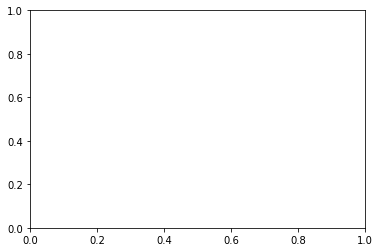

In [77]:
plt.plot(range(1,51),accuracy_history_load[0])
plt.legend()
plt.show()

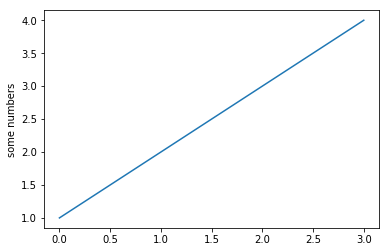

In [67]:
plt.plot([1,2,3,4])
plt.ylabel('some numbers')
plt.show()